# Notes

- Position of the cut-out: For AX Cir and possibly also V659 Cen the position of the Cepheid is off. The companion is so bright that is has diffraction spikes, too, and thus the fit of the diffraction spikes for the position is not good enough.
  
  **Solution**: Use very narrow region for the spike fit. Currently, the spike fit looks for the position of the *maximum* value, not the mean or median, and since the Cepheid is much brighter than the companion that should be OK. (And it looks OK when I checked visually.)


- Positions from diffraction spikes. Looking at the images divided by the median images, the diffraction spikes are clearly sometimes too high and sometimes too low.

   **Result**: I shifted the extraction region up an down by +- 1 pix and compared the fit results. The fit is already the best position I can get for the pixel size I have.
 
 
- LOCI: LOCI fits generally look better, but they need **source free templates**. In some cases, companions from other images are mirrored positive or negative through the PSF fit. In global fits the images with companions will just receive a very low weight (because the companions do not fit, so effectively all base images with companions do not contribute and thus I'm effectively fitting far fewer bases than I thought - presumably that's why my LOCI fits look so much better), but in LOCI the optimization region != fit region. If a base that has a bright companion in the region get just a little weight, the companion will show up in the final image (because it's much brighter than the average sky, even a small coefficient will be enough to make that important). -> need to mask companions *before* first LOCI round. **Iterative approach**. (Later when I run simulations, I can just use the cleaned bases set, so it's OK if there is some manual interaction).


- LOCI: There are still some sectors for some images that are not fit well.

  **Solution**: This is the result of a single (or a few) very high pixels in the optimization region. Dilation of the masked region such that pixels close to masked pixels are not included in the optimization region mostly solves this problem.

## Imports and setup of multiprocessing

In [95]:
import os
from glob import glob
import functools
import copy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn
from astropy import table
from astropy.nddata import Cutout2D, NDData
from astropy.wcs import WCS
from astropy.stats import median_absolute_deviation
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import simple_norm, imshow_norm
from astropy.modeling import models, fitting
from astropy.visualization import (LogStretch, SqrtStretch, PercentileInterval, MinMaxInterval, 
                                   ImageNormalize, AsymmetricPercentileInterval)
from astropy import visualization
from astropy.nddata.utils import overlap_slices

import sherpa
import sherpa.astro.models

from ccdproc import ImageFileCollection
import photutils
from photutils.utils import random_cmap
from photutils import CircularAperture
from photutils.psf import extract_stars

import psfsubtraction

from snapshotprogram.detection import initial_finder, combine_source_tables, stars621, stars845
from snapshotprogram.photometry import initial_fitter_list, flux2mag, betamodel2mag, phot_sherpa

%matplotlib inline

In [2]:
# use the following commands:
# conda_activate Cepheids; ipcontoller --ip='*' --profile=sshCepheids
# and for the workers
# ssh ...
# conda_activate Cepheids ; ipengine --profile=sshCepheids

import ipyparallel

rc = ipyparallel.Client(profile='sshCepheids')
dview = rc[:]
lview = rc.load_balanced_view()
print(len(dview))

3


In [3]:
# Just checking where the engines are running
# mm, does thos help? rc[:].use_cloudpickle()
@dview.remote(block=True)
def getpid():
    import os
    return os.environ['HOST']

getpid()

['melkor.mit.edu', 'melkor.mit.edu', 'melkor.mit.edu']

In [4]:
datadir = '/melkor/d1/guenther/downdata/HST/CepMASTfull/'
fakedir = '/melkor/d1/guenther/processing/Cepheids/fake/'
outdir = '/melkor/d1/guenther/projects/Cepheids/HSTsnapshot/'

# Make a PSF that can be used for model fitting

To make a PRF, I go through all images by hand (simply looking at them in ds9) and select a few with relatively bright, isolated stars that are not too fas off-center, but well outside the regions where the Cepheid PSF matters. There are a few very bright sources, a few more medium bright sources and a lot of relatively faint sources that fullfill these criteria. I'm concentrating on the bright ones, I think there is relatively little benefit from adding in all the faint ones, where the local background level begins to matter.

### Do we need a PRF?

I looked at that in some details, but decided to discard that idea. It is more complicated and I did not select enough sources to really probe the space of sub-sampling enough. Since the PSF is time variable (I see that not only in the Cephedis, but also in the smaller stars) I would want many PRF stars so that for each sub-sample position I have a good average. With the list of stars above, I don't get that; structure in the sub-sampled PRF is visible due to this effect. I used the PRF I got to perform subtractions and found it on average to not be better than the analytical PSF. This, I deleted the notebook cells because it just cluttered the space (this is already a very long notebook!).
I the PRF subtracted images I see positive and negative values in the residuals are well mixed in most cases and the level of the residuals is about 5%. An exception to this is the brightest test star (ibg403010), where the residuals are 15%. Why is this worse for brighter stars? Hard to say, but one possibility is that this particular source is not a single star. Unfortunately, I don't have any other stars that are as bright to test, and even +- 15% is still less then the noise we have after PSF subtraction o the Cepheid for the stars that we are really interested in. 

### Analytical PSF

Let's try an analytical PSF. Our potential candidates are not that bright, so we don't need all the sub-pixel details of the PRF. In addition, I can see that the PSF changes from orbit to orbit (after all, that's why we do all the complex PSF subtraction mechanism in the first place). However, I want to use the same PSF for all orbits for simplicity. So, there is little benefit of going with the more complex PRF formalism, if I can find an analytical function that is so good that the residuals are dominated by statistics and the systematics of the PSF variation. After some experimentation, I settled on a Moffat function with fixed shape parameters (called "Beta2D" in Sherpa).

I initially tried free parameters; there is significant variability between orbits.
However, for our purposes, it seems good enough to use fixed parameters, so after some manual experimentation
I decided to freeze the parameters.

In [6]:
def sherpa_phot(psf, data):
    # Set sensible starting values
    # Use hasattr so I can use the same function for e.g. Gauss2D if I want to try that
    if hasattr(psf, 'alpha') and not psf.alpha.frozen:
        psf.alpha = 2
    if hasattr(psf, 'r0') and not psf.r0.frozen:
        psf.r0 = 2
    psf.ampl = np.max(s.data)
    x, y = np.indices(data.shape)
    dpsf = sherpa.data.Data2D('', x.flatten(), y.flatten(), data.flatten())
    fpsf = sherpa.fit.Fit(dpsf, psf, stat=sherpa.stats.LeastSq())
    fpsf.fit()
    return data - psf(x.flatten(), y.flatten()).reshape(data.shape)  

In [332]:
beta2d = sherpa.astro.models.Beta2D()

for s in stars621:
    out = sherpa_phot(beta2d, s.data)
    print('alpha={:4.1f} r={:4.1f} (x,y)=({:4.1f}, {:4.1f})'. format(beta2d.alpha.val, beta2d.r0.val,
                                                                     beta2d.xpos.val, beta2d.ypos.val))

alpha= 2.9 r= 2.1 (x,y)=( 9.9, 11.1)
alpha= 2.2 r= 1.6 (x,y)=(10.8, 10.9)
alpha= 1.1 r= 0.8 (x,y)=(10.3, 10.5)
alpha= 3.2 r= 2.6 (x,y)=(11.8, 10.8)
alpha= 2.2 r= 1.8 (x,y)=(11.2, 10.8)
alpha= 2.1 r= 1.6 (x,y)=(11.4, 10.8)
alpha= 2.0 r= 1.6 (x,y)=(11.7, 11.0)
alpha= 1.7 r= 1.5 (x,y)=(11.1, 10.9)
alpha= 2.1 r= 1.7 (x,y)=(11.1, 11.4)
alpha= 2.0 r= 1.6 (x,y)=(10.1, 10.9)
alpha= 2.2 r= 1.7 (x,y)=(10.8, 11.2)
alpha= 2.3 r= 1.7 (x,y)=(10.2,  9.9)
alpha= 2.5 r= 1.9 (x,y)=(10.1,  9.9)


In [331]:
beta2d = sherpa.astro.models.Beta2D()

for s in stars845:
    out = sherpa_phot(beta2d, s.data)
    print('alpha={:4.1f} r={:4.1f} (x,y)=({:4.1f}, {:4.1f})'. format(beta2d.alpha.val, beta2d.r0.val,
                                                                     beta2d.xpos.val, beta2d.ypos.val))

alpha= 2.3 r= 1.8 (x,y)=( 9.9, 10.9)
alpha= 1.8 r= 1.4 (x,y)=(10.7, 10.7)
alpha= 1.6 r= 1.4 (x,y)=(10.2, 10.2)
alpha= 2.0 r= 1.9 (x,y)=(12.0, 10.6)
alpha= 1.8 r= 1.4 (x,y)=(11.1, 10.5)
alpha= 1.6 r= 1.2 (x,y)=(11.4, 10.5)
alpha= 1.9 r= 1.5 (x,y)=(11.7, 10.8)
alpha= 1.5 r= 1.3 (x,y)=(11.0, 10.7)
alpha= 2.0 r= 1.6 (x,y)=(11.1, 11.2)
alpha= 2.0 r= 1.6 (x,y)=(10.1, 10.7)
alpha= 2.1 r= 1.6 (x,y)=(10.8, 10.9)
alpha= 2.0 r= 1.6 (x,y)=(10.2,  9.7)
alpha= 2.1 r= 1.7 (x,y)=(10.0,  9.7)


In [8]:
psf_621 = sherpa.astro.models.Beta2D(name='psf_621')
psf_621.alpha = 2.2
psf_621.r0 = 1.7
psf_621.alpha.frozen = True
psf_621.r0.frozen = True

psf_845 = sherpa.astro.models.Beta2D(name='psf_845')
psf_845.alpha = 2
psf_845.r0 = 1.6
psf_845.alpha.frozen = True
psf_845.r0.frozen = True

In [9]:
# Set sensible starting parameters for the fit below
for psf in [psf_621, psf_845]:
    psf.xpos = 11.
    psf.ypos = 11.

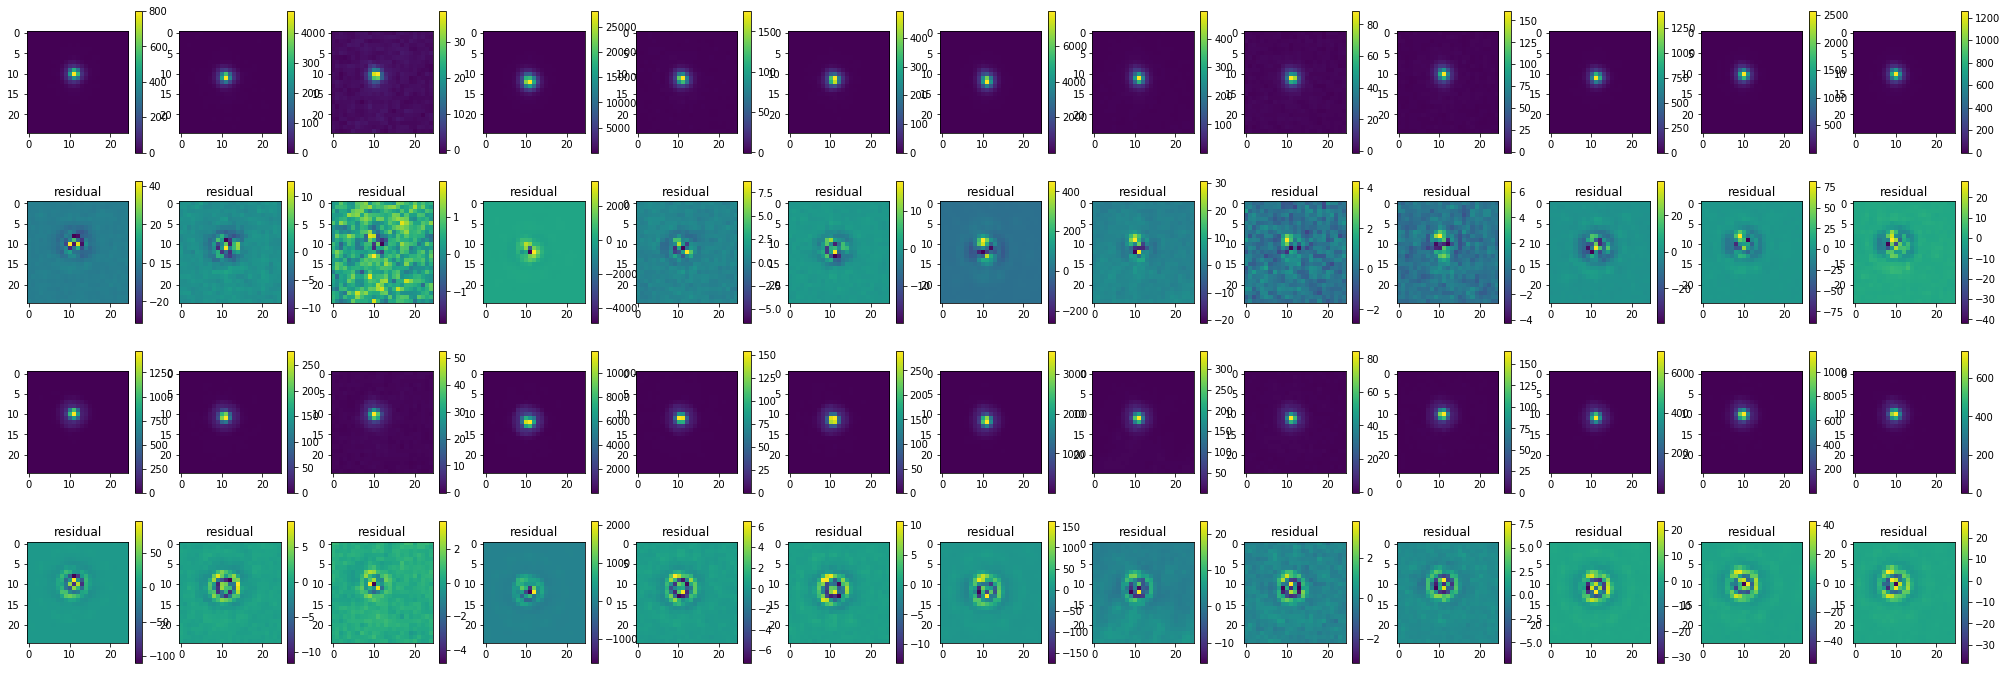

In [10]:
x, y = np.indices(stars621[0].data.shape)

fig, axes = plt.subplots(nrows=4, ncols=13, figsize=(35,12))

for j in range(13):
    for i, stars in enumerate([stars621, stars845]):
        image = stars[j].data
        imout = axes[2 * i][j].imshow(image)
        #axes[0][j].set_title(prftestlist[j][0])
        plt.colorbar(imout, ax = axes[2 * i][j])
        thispsf = [psf_621, psf_845][i]
        photout = sherpa_phot(thispsf, image)
        imout = axes[2 * i + 1][j].imshow(photout)
        axes[2 * i + 1][j].set_title("residual")
        plt.colorbar(imout, ax = axes[2 * i + 1][j])

# Read and preprocess Cepheid images

In [11]:
keys = ['TARGNAME', 'FILTER', 'ASN_ID', 'RA_TARG', 'DEC_TARG', 'DATE-OBS', 'TIME-OBS', 'EXPTIME']
fitslist = ImageFileCollection(datadir, keywords=keys, glob_include='*drz.fits')

In [12]:
fitslist.sort(['FILTER', 'TARGNAME'])

Our goal is to select sub-images that are all centered on the bright Cepheid. Since the Cepheids are all significantly over-exposed and saturated, we cannot just look for the brightest pixel. Instead, we make an inital guess based on the center of mass of the image and then fit lines to the diffraction spikes and use the intersection point as the source position. To make sure that the fit of the diffraction spike is not skewed by the presence of a source close to it, we select a region that is only a few pixels wide for the fit.

In [13]:
initial_guess = functools.partial(psfsubtraction.prepare.center.guess_center_nested, halfwidth=150)

def read_images(filelist, halfwidth, width=5):
    '''Read files, make header wrappers for WCS'''
    images = np.ma.zeros((2 * halfwidth + 1, 2 * halfwidth + 1, len(filelist)))
    images.mask = np.zeros_like(images, dtype=bool)
    targets = []

    for i, f in enumerate(filelist):
        if np.mod(i, 20) == 0:
            print('working on file {0}'.format(i))
        with fits.open(f) as hdus:
            xm, ym = psfsubtraction.prepare.center.center_from_spikes(hdus[1].data, width=width,
                                    initial_guess=initial_guess)
            cutout = Cutout2D(hdus[1].data, (ym, xm), 2 * halfwidth + 1, wcs=WCS(hdus[1].header))
            cutmask = Cutout2D(hdus[2].data, (ym, xm), 2 * halfwidth + 1)
            cutout.TARGNAME = hdus[0].header['TARGNAME']
            cutout.FILTER = hdus[0].header['FILTER']
            targets.append(cutout)
            images[:, :, i] = cutout.data
            images.mask[:, :, i] = cutmask.data == 0
    return images, targets


\section{Observations and data reduction}
\label{sect:obs}

We observed a sample of 70 Cepheides with the \emph{Hubble Space Telescope} using the WFC3 camera to search for binary companions. The data are described in detail in \textbf{insert reference here}. Briefly, each object was observed using two filters (\texttt{F621M} and \texttt{F845M}) which are medium bandpass filteres centered on 621~nm and 845~nm. In each filter, three dither positions were observed with exposure times of a few seconds. The exposure times are set such that the central Cepheid is overexposed by about a factor of a hundred, totally saturating the central part of its point-spread function (PSF). This is necessary to collect sufficient signal for any late-type main sequence companion. In the first paper we dealt with companions located more than 5\arcsec{} from the central source. Here, we concentrate on close companions which can be found after a detailed PSF subtraction.
As described in \textbf{insert reference here}, the data are \textbf{insert what Evan did here if he did more than I say}
reduced using the standard HST/WFC3 pipeline and combined into drizzeled images. 


In [14]:
halfwidth = 60
cutsize = 2 * halfwidth + 1
cutshape = (cutsize, cutsize)
F621Marr, F621M = read_images(fitslist.files_filtered(FILTER='F621M', include_path=True), halfwidth=halfwidth)
F845Marr, F845M = read_images(fitslist.files_filtered(FILTER='F845M', include_path=True), halfwidth=halfwidth)

working on file 0
working on file 20
working on file 40
working on file 60
working on file 0
working on file 20
working on file 40
working on file 60


In [281]:
F621Marr.shape

(121, 121, 70)

In [285]:
np.min(F621Marr[20, 20, :]), np.max(F621Marr[20, 20, :])

(29.213525772094727, 3219.00634765625)

In [15]:
n_images = F621Marr.shape[-1]

In [16]:
F621names = fitslist.summary['TARGNAME'][fitslist.summary['FILTER'] == 'F621M'].tolist()
F845names = fitslist.summary['TARGNAME'][fitslist.summary['FILTER'] == 'F845M'].tolist()
assert np.all(F621names == F845names)

In [17]:
def targname(n):
    n = n.replace('-', ' ')
    n = n.replace('BETA', r'$\beta$')
    n = n.replace('ZETA', r'$\zeta$')
    n = n.replace('ETA', r'$\eta$')
    n = n.replace('DEL', r'$\delta$')
    if ' ' not in n:
        n = n[:-3] + ' ' + n[-3:]
    n = n[:-2] + n[-2:].lower()
    return n

In [18]:
# Currently plot_gallery does not work with wcsaxis. Might be possible to specify the acis class
# or just loop over "add_subplot(... projection='wcs')" when I need it
# The function below might help; it's left over from an earlier implementation

from astropy.visualization.wcsaxes import WCSAxes

def setup_ax_wcs(fig, n_rows, n_cols, index, wcs):
    ax = fig.add_subplot(n_rows, n_cols, index + 1, 
                         projection=wcs)
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    ra.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
    dec.grid(color='g', alpha=0.8, linestyle='solid', linewidth=3)
    ra.set_major_formatter('hh:mm:ss.s')
    return ax

In [19]:
def plot_gallery(images, names=None, figsize=(15, 20),
                 axesgrid_kwargs = {'nrows_ncols': (10, 7), 'axes_pad':(0.02, .3)}, 
                 imshow_norm_kwargs={'stretch': LogStretch()}):
    fig = plt.figure(figsize=figsize)
    grid = AxesGrid(fig, 111, **axesgrid_kwargs)
    for i in range(len(grid)):
        im = imshow_norm(images[:,:, i], ax=grid[i], origin='lower', **imshow_norm_kwargs)
        #grid.cbar_axes[i].colorbar(im[0])
        if names is not None:
            grid[i].set_title(targname(names[i]))
    return fig, grid

def add_sources_to_gallery(axgrid, names, cutouts, sources, xname='xcentroid', yname='ycentroid', r=5, **kwargs):
    if len(axgrid) != len(names):
        raise ValueError('Need to supply one name for each ax')
    if len(axgrid) != len(cutouts):
        raise ValueError('Need to supply one cutout with wcs for each ax')
    for i in range(len(axgrid)):
        src = sources[sources['TARGNAME'] == names[i]]
        if len(src) > 0:
            apertures = CircularAperture(zip(src[xname], src[yname]), r=r)
            apertures.plot(ax=axgrid[i], **kwargs)

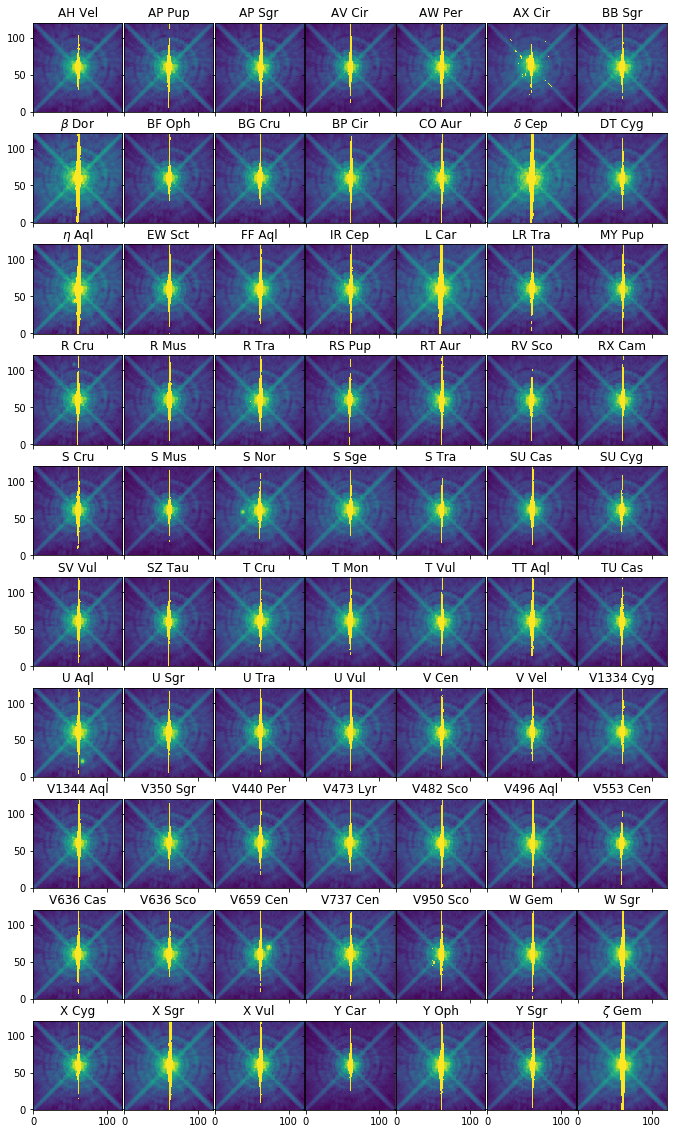

In [20]:
fig = plot_gallery(F621Marr, F621names)

In [21]:
def mask_saturated(images, maskingfunc):
    '''Mask pixels above a certain value
   
    Parameters
    ----------
    image : np.array
        2d or 3d array of images (if 2d, then array of flattend images)
    maskingfunc : callable
        This function is called for every image. It returns as boolean mask
        that is ``True`` for all values that should be masked.
    '''
    for i in range(images.shape[-1]):
        images[maskingfunc(images[..., i]), i] = np.ma.masked
    return images

Now, we want to create a median image. 

In [22]:
normperimF621 = np.ma.median(F621Marr, axis=(0, 1))
normperimF845 = np.ma.median(F845Marr, axis=(0, 1))

medianimF621 = np.ma.median(F621Marr / normperimF621, axis=2)
medianimF845 = np.ma.median(F845Marr / normperimF845, axis=2)

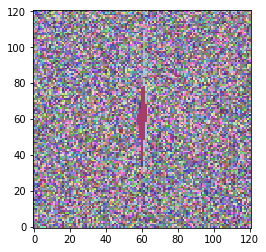

In [23]:
# Check that a variety of images contribute to the median image. 
# If that is not the case, the normalization did not work and we risk finding features from an individual images
# (in worst case a companion) in the median image.
indim = np.argmin(np.abs(F621Marr/normperimF621 - medianimF621[:, :, None]), axis=2)
out = plt.imshow(indim, interpolation='nearest', origin='lower', 
                 cmap=random_cmap(n_images, random_state=12345))

Text(0.5, 1.0, 'Median image F845M')

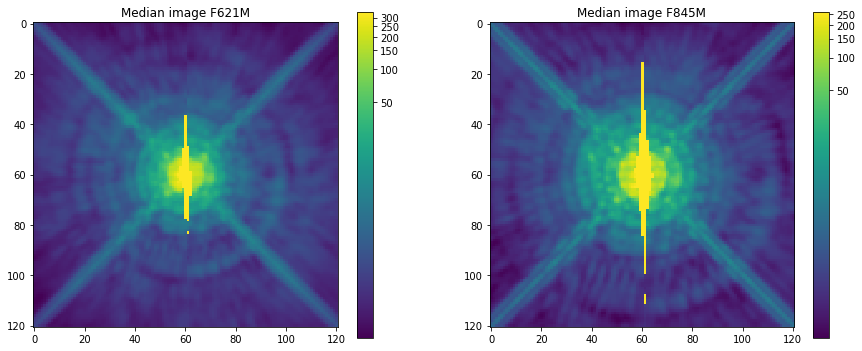

In [24]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)

im1 = imshow_norm(medianimF621, ax=ax1, stretch=LogStretch())
plt.colorbar(im1[0], ax=ax1)
ax1.set_title('Median image F621M')

ax2 = fig.add_subplot(122)
im2 = imshow_norm(medianimF845, ax=ax2, stretch=LogStretch())
plt.colorbar(im2[0], ax=ax2)
ax2.set_title('Median image F845M')             

\section{PSF subtraction}

\subsection{Introduction}
referneces here

\subsection{mmm}
 - cutout based on centering based on spikes
-masking saturated pixels
- cannot transform bases like KLIP because of masked pixels
- fit different regions / bases


We apply two transformations to the drizzeled images in order to normalize them in a way that increases the numerical stability of the PSF fitting. After masking pixels that are saturated, we divide each image by its median value. Given the size of the images, the median value represents the power in the wings of the Cephedid PSF, so this transformation brings all images to a similar scale despite the different exposure times and magnitudes of the Cepheids. Second, we divide each image by the median image. Our fitting procedure is essentially a $\chi^2$ optimization with equal weights for each pixel (see below). The error term that is minimized in such a procedure it dominated the by pixels with the largest \emph{absolute} deviation. These are found in the inner part of the PSF, usually just next to the saturated pixels. However, these pixels are very uncertain for fitting the PSF, because we cannot exclude that some of them have received extra charge through bleeding. Also, our masking procedure means that those pixels are often covered by few bases only in the fit, again making the fit less reliable. By dividing each image by the median image, we ensure that the absolute numerical value in each pixel is similar, putting more weight on the other parts of the PSF.

In [25]:
normF621 = F621Marr.copy() / normperimF621 / medianimF621[..., None]
normF845 = F845Marr.copy() / normperimF845 / medianimF845[..., None]

See plots for the median normalized images below where I do source detection on them.

# Find initial source list
This list does not have to be perfect, but it does have to cover the brightest of the companion sources so that the areas that show a companion can be masked and are not used as PSF template for the remaining images. The final procedure can be done iteratively, where all additional companions found in the next step can be added to the list, but we have to start somewhere.

Since we don't have any reduced images yet, we might so the detection on the median normalized images or build that list by hand. Really, anything goes at this step because this just sets the initial values for the fit later.

In [26]:
src_F621M_initial = []
src_F845M_initial = []


for i in range(F621Marr.shape[-1]):
    src_F621M_initial.append(initial_finder(normF621[:, :, i], mask=normF621[:, :, i].mask))
    src_F845M_initial.append(initial_finder(normF845[:, :, i], mask=normF845[:, :, i].mask))
    
sources_initial = combine_source_tables(src_F621M_initial, src_F845M_initial, F621names, dmax=None, 
                                xname='xcentroid', yname='ycentroid')    

In [27]:
def radec2xy(cutoutlist, name, ra, dec):
    '''
    Parameters
    ----------
    cutoutlist : list of astropy.nddata.utils.Cutout2D objects
        The WCS in the curouts is used to transform RA, DEC to pixel coordinates.

    '''
    i = F621names.index(name)
    c = cutoutlist[i]
    return c.wcs.all_world2pix(ra, dec, 0)

In [28]:
# Now add sources that are so bright and saturated that the procedure above does not find them.
x, y = radec2xy(F621M, 'V659-CEN',  202.8888 * u.deg, -61.58242 * u.deg)
sources_initial.add_row([1, x, y, np.nan, np.nan, np.nan, 0, 0, 1000, 100, np.inf, 'HAND', 'V659-CEN'])

x, y = radec2xy(F621M, 'AX-CIR',  223.14685 * u.deg, -63.80977 * u.deg)
sources_initial.add_row([1, x, y, np.nan, np.nan, np.nan, 0, 0, 1000, 100, np.inf, 'HAND', 'AX-CIR'])

# ETA-AQL
x, y = radec2xy(F621M, 'ETA-AQL', 298.11834 * u.deg, 1.00564 * u.deg)
sources_initial.add_row([1, x, y, np.nan, np.nan, np.nan, 0, 0, 1000, 100, np.inf, 'HAND', 'ETA-AQL'])    

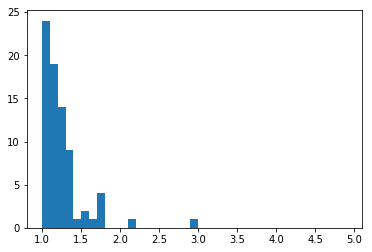

In [29]:
out = plt.hist(sources_initial['flux'], bins=np.arange(1, 5, .1))

In [30]:
# Get rif of the faint stuff that's not looking real:
sources_initial = sources_initial[sources_initial['flux'] > 1.4]

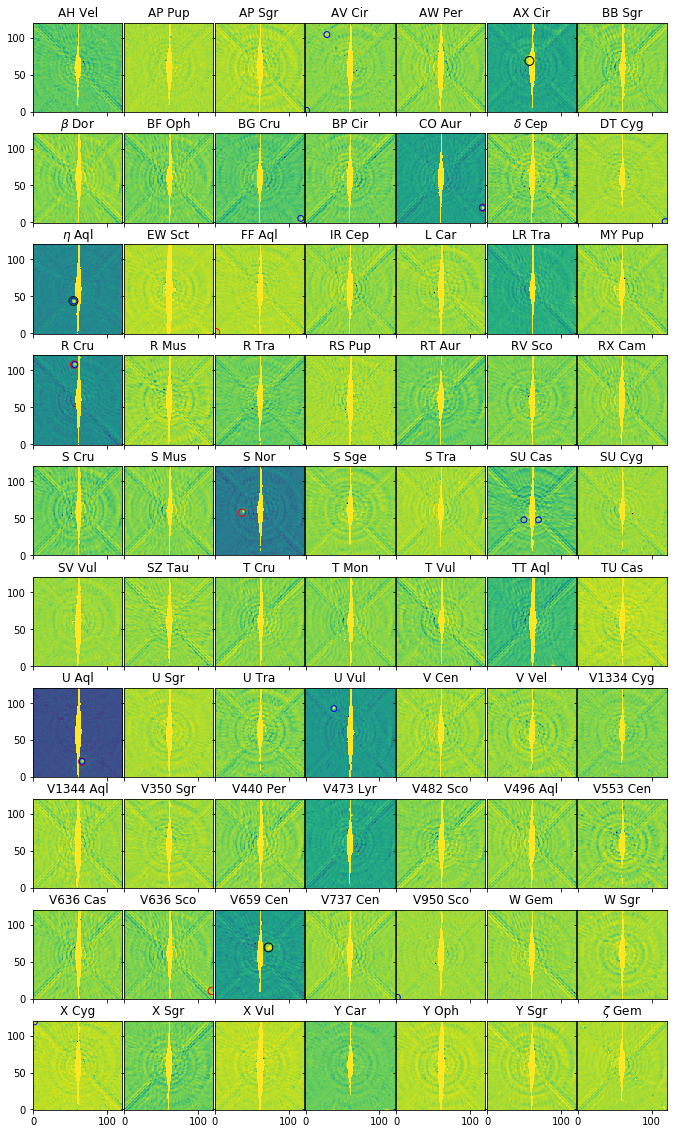

In [31]:
fig, axgrid = plot_gallery(normF845, F621names) #, imshow_norm_kwargs={'stretch': visualization.LinearStretch()})
add_sources_to_gallery(axgrid, F621names, F621M, sources_initial[sources_initial['filter'] == 'F621M'], 
                       xname='xcentroid', yname='ycentroid', r=5, color='r')
add_sources_to_gallery(axgrid, F621names, F621M, sources_initial[sources_initial['filter'] == 'F845M'], 
                       xname='xcentroid', yname='ycentroid', r=4, color='b')
add_sources_to_gallery(axgrid, F621names, F621M, sources_initial[sources_initial['filter'] == 'HAND'], 
                       xname='xcentroid', yname='ycentroid', r=6, color='k')

Most of these sources look real. Some might be noise (in particular in the corners of the images) and some faint objects that are probably real are missed. That's OK since this list is not meant to be a real list of detections, it's just used for an initial guess of the masking to reduce the number of subtractions that are disturbed by the presence of a source in any of the bases.

Real sources should certainly not be used as a base in the subtraction procedure; on the other hand, excluding some regions that turn out to be noise, not real sources, does little harm - at the very least we know that those regions are noisy.

In [32]:
from snapshotprogram.photometry import initial_fitter_list

In [33]:
def mask_suspected_sources(psfbase, sourcelist, radius_in_pix=15):
    '''Set mask for all those regions defined in sourcelist.
    
    Parameters
    ----------
    psfbase : np.ma.array of shape (n, m, k)
        PSF base array
    sourcelist : list or Table
        List of sources to be masked out as a result of a source detection algorithm
    
    Returns
    -------
    psfbase : np.ma.array of shape (n, m, k)
        PSF base array with changes mask. Changes are done *in place* and there is *no*
        copy by default - the input ``psfbase`` object will be modified.
    '''
    x, y = np.indices(psfbase.shape[:2])
    for row in sourcelist:
        i = F621names.index(row['TARGNAME'])
        ind = (x-row['ycentroid'])**2+(y-row['xcentroid'])**2 < radius_in_pix**2    
        psfbase[ind, i] = np.ma.masked
        
    return psfbase
        

In [286]:
sources_initial

<Table masked=True length=22>
  id      xcentroid          ycentroid      ... filter TARGNAME
int64      float64            float64       ...  str5    str8  
----- ------------------ ------------------ ... ------ --------
    1 1.3883508260785407 1.4945390010975732 ...  F845M   AV-CIR
    2  28.86170522548948 104.25420464614365 ...  F845M   AV-CIR
    1 116.31156062984428  5.421992687916815 ...  F845M   BG-CRU
    1 117.63129019585843  19.90546346966395 ...  F621M   CO-AUR
    1 116.51805186575955 19.996308880216933 ...  F845M   CO-AUR
    1 118.39356779754235 1.1237684583468752 ...  F845M   DT-CYG
    1  54.84786101227923 43.729713338683375 ...  F845M  ETA-AQL
    1 1.5006597335758323 1.3889778040579697 ...  F621M   FF-AQL
    1  55.05157599040514 107.85762575019075 ...  F621M    R-CRU
    1  55.97526171387518  107.8367496062465 ...  F845M    R-CRU
    1  36.65556347024352 57.350822628772065 ...  F621M    S-NOR
    2  49.89388487408982 47.749037975554934 ...  F845M   SU-CAS
    3  69.64393924131294 47.707514636529176 ...  F845M   SU-CAS
    1  66.16232338768373 20.559222360428027 ...  F621M    U-AQL
    1  65.90873373097949 20.913500250726432 ...  F845M    U-AQL
    1 38.427147440974146  92.44902083689463 ...  F845M    U-VUL
    1   118.731197728698 10.258655326338467 ...  F621M V636-SCO
    1 1.4126398667967623 1.5803227545626146 ...  F845M V950-SCO
    1   1.21650736516037 118.58439104686892 ...  F845M    X-CYG
    1  72.56721227574411   69.3060926277744 ...   HAND V659-CEN
    1  57.41239310598632  68.53135217723582 ...   HAND   AX-CIR
    1  54.22372784758346 43.715410675909006 ...   HAND  ETA-AQL

In [34]:
baseF621 = mask_suspected_sources(normF621.copy(), sources_initial, radius_in_pix=10)
baseF845 = mask_suspected_sources(normF845.copy(), sources_initial, radius_in_pix=10)

Now we treat the few cases with bright, saturated companions by hand. Just masking the source is not enough here since I can see the diffraction spike of the companion by eye with the right image scaling. Thus, we need to put a mask over the diffraction spikes of the companion, too. Those sources are the same ones that we added by hand to the list of potential sources above, because they were too right to be found by the source detection algorithm (their centers are saturated).

In [35]:
from scipy import ndimage
# Make big convolution mask
structure = np.eye(cutsize * 2, dtype=bool)  # one diagonal
structure = structure | structure[:, ::-1]   # mirror diagonal
structure = ndimage.binary_dilation(structure, np.ones((3, 3), dtype=bool)) # dilate to make wider

In [36]:
# Now mask out diffraction spikes from companions which are so bright that they are
# saturated themselves and I had to add them by hand to the list
for src in sources_initial[sources_initial['filter'] == 'HAND']:
    xmask = np.zeros((cutsize, cutsize), dtype=bool)
    xmask[int(src['ycentroid']), int(src['xcentroid'])] = True
    xmask = ndimage.binary_dilation(xmask, structure)
    i = F621names.index(src['TARGNAME'])
    baseF621.mask[:, :, i] = xmask | baseF621.mask[:, :, i]
    baseF845.mask[:, :, i] = xmask | baseF845.mask[:, :, i]

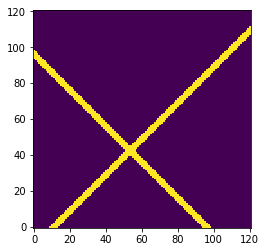

In [37]:
# Just a check that the logic above works correctly. It's easy to mess up indices.
plt.imshow(xmask, origin='lower')

In [38]:
fitterlist621 = initial_fitter_list(baseF621, normF621)
fitterlist845 = initial_fitter_list(baseF845, normF845)

for i in range(len(fitterlist621)):
    fitterlist621[i].manual_optmask = baseF621.mask[:, :, i]
    fitterlist845[i].manual_optmask = baseF845.mask[:, :, i]   

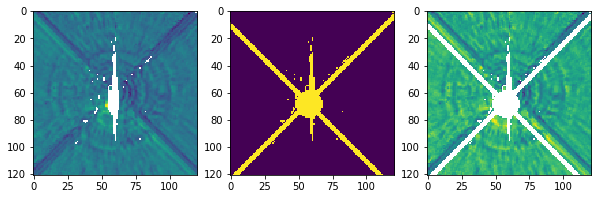

In [39]:
# Check (for one case) that the masking worked
fig = plt.figure(figsize=(10,5))

i = F621names.index('AX-CIR')

ax1 = fig.add_subplot(131)
im1 = ax1.imshow(np.log(normF621[:,:,i]), interpolation="none")

ax2 = fig.add_subplot(132)
im2 = ax2.imshow(baseF621[:,:, i].mask, interpolation="none")

ax3 = fig.add_subplot(133)
im3 = ax3.imshow(np.log(baseF621[:,:,i]), interpolation="none")


## Remove PSF for all images, taking into account initial masking

In [40]:
asyncres621 = lview.map_async(lambda x: x.remove_psf(), fitterlist621)
asyncres845 = lview.map_async(lambda x: x.remove_psf(), fitterlist845)

## Inspect one fitting process in detail to make sure it all works
While the fitting runs in parallel on several machines, we can manually look at one or two examples here to check that it all works correctly and to understand which type of problems might occur.

In [41]:
testfitter = fitterlist621[7]
testregions = list(testfitter.regions())
res = testfitter.remove_psf()

/nfs/melkor/d1/guenther/soft/anaconda/envs/Cepheids/lib/python3.7/site-packages/psfsubtraction-0.0.dev83-py3.7.egg/psfsubtraction/fitpsf/optregion.py:210: UserWarning: Fit underdetermined. Choose larger optimization region or smaller base.
  warn('Fit underdetermined. Choose larger optimization region or smaller base.')


In [42]:
n_regions = []
len_regions = []

# Just look at first few because it takes a while to run otherwise
for i in range(10):
    regs = list(fitterlist621[i].regions())
    n_regions.append(len(regs))
    len_regions.append([r.sum() for r in regs])

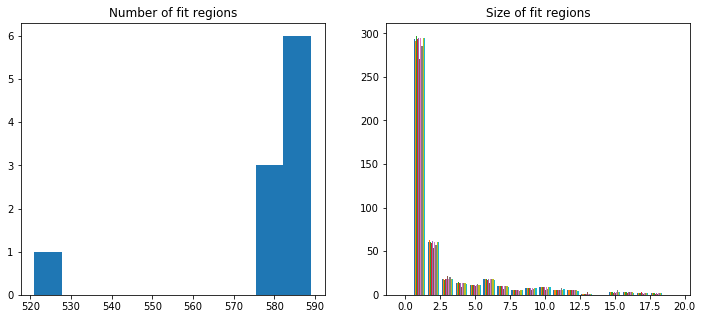

In [43]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))

axes[0].set_title('Number of fit regions')
out = axes[0].hist(n_regions)
axes[1].set_title('Size of fit regions')
for i in range(len(n_regions)):
    temp = axes[1].hist(len_regions, bins=np.arange(-.5, 20, 1))

So, for typical cases (simply looking at a random (first few) subset of the list, we see how many regions we fit in most sources. The exact numbers obviously depends strongly on the size of the fully saturated region. Because these regions differ from image to image, most of the fits just bordering it are done for just a single or very few pixels. If the saturated regions is large, there will be comparatively fewer of the single-pixel regions. 
Similarly, this means that most of the fit regions are actually very small (just one or a few pixels), while most of the area is made up from fewer, larger regions.

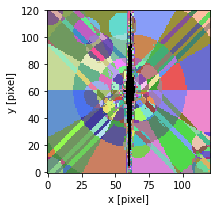

In [280]:
regid = np.zeros(testfitter.image_dim)
for i, r in enumerate(testregions):
    regid[testfitter.anyreg_to_mask(r).reshape(testfitter.image_dim)] = i
    
# Region 0 is masked in this image. Make that black.
cmap=random_cmap(len(testregions), random_state=12345)
cmap.colors[0] = [0, 0, 0]



fig, ax = plt.subplots(figsize=(4,3))
out = ax.imshow(regid, interpolation='nearest', origin='lower', cmap=cmap)
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]')

fig.savefig('../fit_regions.pdf', bbox_inches='tight')

This plot shows for one example, how the fitted regions are set up. In general, we divide the entire cutout fitted with this method into radial sectors. The rings are small in the center and become successively larger further away from the Cepheid. We use segments, because we know that the PSF is not radially symmetric, thus changes in the PSF are likely to be more correlated with other changes close-by in location than with changes on the other side of the Cepheid. The size of the regions chosen is a trade-off already described in the LOCI paper (reference here). Smaller regions are expected to give better results, but are computationally more intensive.

Each sector can be split into more than one fitting region. For example, is a (potential) companion is identified in one image, the part of the image that contains the companion cannot be used for fitting, since that companion is not part of the Cepheid PSF. We place a circular mark over each companion candidate, but we still want to make use of that image in those parts that are not effected by the companion - we simply cannot afford to ignore every image that has a companion candidate somewhere. Thus, we split the sector into two regions, one where we can use all images as bases for the PSF fit, and one where we can use all but the one with the potential companion. In a similar fashion, we mask out possible diffraction spikes and other instrumental artifacts, leading to the patchwork for fitting regions of different size that is visible in the image.

The black region is what is masked as saturated in this image and thus will not be fit at all.

In [274]:
for treg in testregions:
    testbase = testfitter.findbase(treg)
    indpsf = testfitter.baseind_to_mask(testbase)
    optregion = testfitter.anyreg_to_mask(testfitter.optregion(treg, indpsf))
    if treg.sum() > 200 and optregion.sum() > 10:
        break


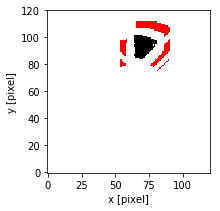

In [279]:
from matplotlib.colors import LinearSegmentedColormap
cm = LinearSegmentedColormap.from_list('cmapregions', [(1, 1, 1),(0, 0, 0),(1, 0, 0)], N=3)

image = np.zeros(testfitter.image_dim)
image[treg.reshape(testfitter.image_dim)] = 1
image[optregion.reshape(testfitter.image_dim)] = 2
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(image, origin='lower', cmap=cm)
ax.set_xlabel('x [pixel]')
ax.set_ylabel('y [pixel]')

fig.savefig('../fit_region.pdf', bbox_inches='tight')

This figure shows one example of the fitting process for each individual region. Shown in black is the region where we want to know the PSF subtraction. However, we cannot us the same region to optimize our fit. If the region contains some fraction of the PSF of the Cepheid, but also a companion and we used the same blue region to optimize our fit, we would oversubtract the PSF. For large fit regions this is not a problem, but when the size of the fit region becomes comparable to the size of the PSF for a potential companion, then we need to take care not to subtract out those companions while trying to fit the Cepheid PSF. Thus, the fit is optimized using a larger, separate region (red). Again, there is some trade-off here: If the yellow regions is too close to the blue region, we would subtract out some of the companion flux, if it is too far, we will not obtains a good fit for the Cepheid PSF any longer.

## Continue working on the full set of fitted PSFs
First cell check that all calculations are done, just to make sure I don't get stuck here forever waiting for other processes to finish.

In [49]:
# Check with "if" to avoid blocking the notebook when I accidentially execute this cell.
if asyncres621.ready():
    initial_fits_621 = asyncres621.get()
else:
    print("621 Not ready yet")

if asyncres845.ready():
    initial_fits_845 = asyncres845.get()
else:
    print("845 Not ready yet")

In [50]:
rc.queue_status()

{'unassigned': 0,
 0: {'queue': 1, 'completed': 0, 'tasks': 0},
 1: {'queue': 0, 'completed': 48, 'tasks': 0},
 2: {'queue': 0, 'completed': 50, 'tasks': 0},
 3: {'queue': 0, 'completed': 48, 'tasks': 0}}

In [51]:
reduced_images621 = np.ma.dstack(initial_fits_621) * normperimF621 * medianimF621[..., None]
reduced_images845 = np.ma.dstack(initial_fits_845) * normperimF845 * medianimF845[..., None]

In [52]:
# Not efficient in terms of memory, but fast to program and generates only a single file
# which I can use as input for MC simulations for detectability
import pickle

# Original images? Or just read again
# Decide when code works here, but simplest way might be to just write out more
# and have one file that has all inputs for MC simulations
vars2keep = ['F621Marr', 'F845Marr',
             'baseF621', 'baseF845', 
             'normperimF621', 'normperimF845', 
             'medianimF621', 'medianimF845',
             ]

data = {n: globals()[n] for n in vars2keep} 

with open(os.path.join(fakedir, 'Cephsubtracted.pickle'), 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

### Investigate backgrounds

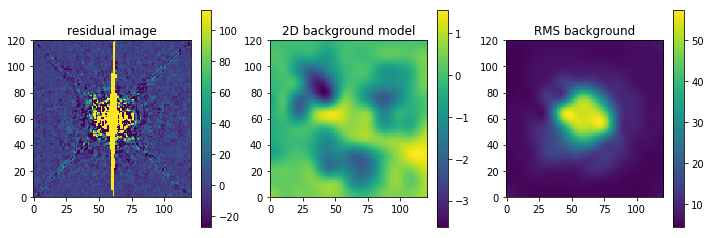

In [53]:
i = F621names.index('R-CRU')
i=20
data = reduced_images621[:, :, i].copy()
bkg = photutils.background.Background2D(data.data, box_size=(10,10), mask=baseF621.mask[:,:, i])

fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(131)
norm = simple_norm(data, 'linear', percent=92.)
im1 = ax1.imshow(data, interpolation="none", origin='lower', norm=norm)
ax1.set_title('residual image')
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(132)
ax2.set_title('2D background model')
im2 = ax2.imshow(bkg.background, interpolation="none", origin='lower')
plt.colorbar(im2, ax=ax2)

ax3 = fig.add_subplot(133)
ax3.set_title('RMS background')
im3 = ax3.imshow(bkg.background_rms, interpolation="none", origin='lower')
plt.colorbar(im3, ax=ax3)

The plot above shows and a residual image after the PSF subtraction, a smoothed background model and the RMS of that background. The smooth background show show few features. If we see PSF features here, they are not subtracted well, if we see companions then the companion fitting will not go well. I looked a several of those images and the range in the background is small. The next check if the RMS of the background. It's supposed to be larger in the center where (i) the total count rates and thus the noise is higher and (ii) more is going on with the Cepheid. In a later section when we do PSF fitting of the companions, this will tell use the noise from the background alone and thus sets a limit on how good the PSF has to be.

# Source detection

## Inserting fake companions to find best source detection parameters

In order to select the parameters for the source finding and source extraction I need to look at sources with known characteristics. One way to do that is by adding fake sources with a known position and flux and run the detection pipeline and see how well I recover that. The same procedure can be used to evaluate the detection thresholds later. In order to have realistic sources I'll insert copies of a few well-exposed single stars (those that I selected to determine the PSF parameters). In theory, I have to be worry about overfitting. The sources used to construct the PSF parameters will fit the PSF better than an average source, but since I know fit 2 parameters and have > 10 sources, that's probably fine and I have only a limited supply of bright, single stars to use.

Similarly, I can't technically use the same simulations to determine the parameters for the source detection and photometry that I use to determine the detection efficiency, but in practice, it's probably OK if I just run enough simulations or run new simulations with the same code.

Insert a fake source into a single image. Then, for the image above, select the corresponding image in the other band. Insert a random fake source at the same position into the corresponding image. In that way, I can test the two-band detection and fitting routines. The origin of the fake source is not necessarily the same (but it could be randomly). Since our PSF it is not perfect and we occasionally see small offsets in the coordinate system, using different PSF stars as fake sources mimics some of this variability.

In [54]:
name = 'outside_1'
src = Table.read(fakedir + name + '_detect.fits')
phot = Table.read(fakedir + name + '_phot.fits')

src['dist'] = np.sqrt((src['xcentroid'] - src['xin'])**2 + (src['ycentroid'] - src['yin'])**2)
phot['dist'] = np.sqrt((phot['x_621'] - phot['xin'])**2 + (phot['y_621'] - phot['yin'])**2)

for tab in [src, phot]:
    for c in tab.columns:
        if np.issubdtype(tab[c].dtype, np.floating):
            tab[c].format = '5.1f'

In [55]:
((10.6-10.9)**2 + (29.7-27.8)**2)**0.5

1.9235384061671332

In [56]:
src

<Table length=212>
  id  xcentroid ycentroid sharpness roundness1 ...  yin   f621in  f845in   dist 
int64  float64   float64   float64   float64   ... int64 float64 float64 float64
----- --------- --------- --------- ---------- ... ----- ------- ------- -------
    1      10.6      29.6       0.6       -0.3 ...    30 10000.0 10000.0     0.7
    1      10.8      27.8       0.6        0.2 ...    30 10000.0 10000.0     2.3
    1      10.4      28.4       0.6        0.2 ...    30 10000.0 10000.0     1.7
    2      55.1     107.9       0.7       -0.1 ...    30 10000.0 10000.0    90.0
    1      10.6      29.9       0.6       -0.1 ...    30 10000.0 10000.0     0.6
    2      56.0     107.8       0.6        0.4 ...    30 10000.0 10000.0    90.4
    1       9.8      28.1       0.7       -0.0 ...    30 10000.0 10000.0     1.9
    1       9.6      28.0       0.6        0.1 ...    30 10000.0 10000.0     2.1
    1      10.4      28.4       0.6        0.3 ...    30 10000.0 10000.0     1.7
    1       9.7      28.1       0.6       -0.0 ...    30 10000.0 10000.0     1.9
  ...       ...       ...       ...        ... ...   ...     ...     ...     ...
    1      10.8      29.7       0.7        0.3 ...    30 10000.0 10000.0     0.9
    1      10.9      28.8       0.7        0.2 ...    30 10000.0 10000.0     1.5
    1      11.0      28.9       0.7        0.0 ...    30 10000.0 10000.0     1.5
    1      10.6      28.1       0.6        0.1 ...    30 10000.0 10000.0     2.0
    1      11.3      29.1       0.7        0.3 ...    30 10000.0 10000.0     1.5
    1      10.8      29.6       0.6        0.3 ...    30 10000.0 10000.0     0.9
    1       9.8      28.2       0.7       -0.0 ...    30 10000.0 10000.0     1.8
    1      10.6      28.1       0.6        0.0 ...    30 10000.0 10000.0     2.0
    1      11.2      29.1       0.7        0.1 ...    30 10000.0 10000.0     1.5
    1       9.6      28.0       0.6        0.1 ...    30 10000.0 10000.0     2.1

In [57]:
det621 = ((src['filter'] == 'F621M') & (src['dist'] < 2.5)).sum()
det845 = ((src['filter'] == 'F845M') & (src['dist'] < 2.5)).sum()

In [58]:
# Get list of target names where the inserted source is detected in at least 1 band
atleast1bandnames = np.unique(src['TARGNAME'][src['dist'] < 2.5])
len(atleast1bandnames)

100

In [59]:
ind = np.isin(phot['TARGNAME'], atleast1bandnames) & (phot['dist'] < 5)

In [60]:
ind.sum()

200

In [61]:
phot

<Table masked=True length=212>
TARGNAME  y_621   x_621   y_845   x_845  ...  xin   yin   f621in  f845in   dist 
 bytes7  float64 float64 float64 float64 ... int64 int64 float64 float64 float64
-------- ------- ------- ------- ------- ... ----- ----- ------- ------- -------
  FAKE_0    29.3    10.6    27.9    10.8 ...    10    30 10000.0 10000.0     0.9
  FAKE_0    29.4    10.6    28.0    10.9 ...    10    30 10000.0 10000.0     0.9
  FAKE_1    28.3    10.4    29.9    10.6 ...    10    30 10000.0 10000.0     1.7
  FAKE_1   107.8    55.2   107.8    55.9 ...    10    30 10000.0 10000.0    89.9
  FAKE_1    28.3    10.4    29.9    10.6 ...    10    30 10000.0 10000.0     1.8
  FAKE_1   107.8    55.2   107.8    55.9 ...    10    30 10000.0 10000.0    89.9
  FAKE_2    28.1     9.9    28.0     9.7 ...    10    30 10000.0 10000.0     1.9
  FAKE_2    28.1     9.9    28.0     9.7 ...    10    30 10000.0 10000.0     1.9
  FAKE_3    28.3    10.4    28.2     9.7 ...    10    30 10000.0 10000.0     1.7
  FAKE_3    28.3    10.4    28.2     9.7 ...    10    30 10000.0 10000.0     1.7
     ...     ...     ...     ...     ... ...   ...   ...     ...     ...     ...
 FAKE_95    29.9    10.2    28.4    11.1 ...    10    30 10000.0 10000.0     0.2
 FAKE_95    29.7    10.2    28.4    11.3 ...    10    30 10000.0 10000.0     0.4
 FAKE_96    30.5    10.6    26.9    12.3 ...    10    30 10000.0 10000.0     0.8
 FAKE_96    30.1    11.0    26.1    12.3 ...    10    30 10000.0 10000.0     1.0
 FAKE_97    30.9    10.8    29.5    12.5 ...    10    30 10000.0 10000.0     1.2
 FAKE_97    30.7    10.8    29.4    12.6 ...    10    30 10000.0 10000.0     1.0
 FAKE_98    26.6     9.3    27.6    11.1 ...    10    30 10000.0 10000.0     3.5
 FAKE_98    26.7     9.3    27.7    10.9 ...    10    30 10000.0 10000.0     3.4
 FAKE_99    27.5    12.2    27.1     9.2 ...    10    30 10000.0 10000.0     3.3
 FAKE_99    28.0    11.6    26.9     9.1 ...    10    30 10000.0 10000.0     2.5

In [62]:
photvalid = (phot['dist'] < 2.5) & np.isfinite(phot['mag_621']) & np.isfinite(phot['mag_845'])
print("m_621: {:4.1f} and m_845: {:4.1f} gives detection fraction {:5.2f}".format(flux2mag(phot['f621in'][0], 'F621M'),
                                                                   flux2mag(phot['f845in'][0], 'F845M'),
                                                                   photvalid.sum() / phot.meta['N_RUNS']))

m_621: 14.5 and m_845: 13.3 gives detection fraction  1.54


In [338]:
pos1 = SkyCoord(*F621M[0].wcs.all_pix2world(10, 10, 0), unit='deg')
pos2 = SkyCoord(*F621M[0].wcs.all_pix2world(10, 11, 0), unit='deg')
pixsize = pos1.separation(pos2).arcsec
print(pixsize)

0.03962000080559992


In [346]:
outtab.colnames

['TARGNAME',
 'y_621',
 'x_621',
 'y_845',
 'x_845',
 'mag_621',
 'mag_845',
 'x_0',
 'y_0',
 'residual_image_621',
 'residual_image_845',
 'separation',
 'P.A. (E of N)']

In [374]:
def plot_fakeresults(name, binsize=.25, target=None, table=None):
    filenames = glob(fakedir + name + '*_phot.fits')
    filenames.sort()
    fig, axes = plt.subplots(ncols=3, figsize=(7, 2.5))
    color = 'rgbycmkr'
    for i, f in enumerate(filenames):
        src = Table.read(f.replace('phot.fits', 'detect.fits'))
        if target is None:
            image = medianimF621
        else:
            image = F621Marr[:, :, F621names.index(target)]
        im1 = imshow_norm(medianimF621, ax=axes[0], stretch=LogStretch(),
                          extent=(-halfwidth * pixsize, halfwidth * pixsize,
                                  -halfwidth * pixsize, halfwidth * pixsize), alpha=.3)
        axes[0].plot((src['xin'] - halfwidth) * pixsize, (src['yin'] - halfwidth) * pixsize, 'r.')
        phot = Table.read(f)
        phot['dist'] = np.sqrt((phot['x_621'] - phot['xin'])**2 + (phot['y_621'] - phot['yin'])**2)
        photvalid = (phot['dist'] < 2.5) & np.isfinite(phot['mag_621']) & np.isfinite(phot['mag_845'])
        photvalid = (phot['dist'] < 2.5) & np.isfinite(phot['mag_621']) & np.isfinite(phot['mag_845'])
        phot = phot[photvalid]
        # phot can have two entries for the same source in the same image if the source
        # was initially found in both bands
        # For the real data, we do the merging by hand, but here we need code to do that
        temp, ind = np.unique(phot['TARGNAME'], return_index=True)
        if len(ind) > 0:
            phot = phot[ind]
            print("m_621: {:5.2f} and m_845: {:5.2f} gives detection fraction {:5.2f}".format(flux2mag(phot['f621in'][0], 'F621M'),
                                                                   flux2mag(phot['f845in'][0], 'F845M'),
                                                                   len(phot) / phot.meta['N_RUNS']))
            axes[0].plot((phot['xin'] - halfwidth) * pixsize, (phot['yin'] - halfwidth) * pixsize, 'k.')
            axes[0].set_xlim(-2.4, 2.4)
            axes[0].set_ylim(-2.4, 2.4)
            axes[0].grid(True)
            axes[0].set_aspect('equal')
            for j, f in enumerate(['621', '845']):
                axes[1 + j].hist(phot['mag_{}'.format(f)], bins=np.arange(10,20,binsize), color=color[i], alpha=.3)
                inputmag = flux2mag(phot['f{}in'.format(f)][0], 'F{}M'.format(f))
                axes[1 + j].vlines(inputmag, 0, 10, color=color[i])
                axes[1 + j].set_title(f'F{f}M')
                axes[1 + j].set_xlabel('mag detected')
        if table is not None:
            row = table[table['TARGNAME'] == target]
            axes[0].plot((row['x_621'] - halfwidth) * pixsize, (row['y_621'] - halfwidth) * pixsize, 'm*')
        else:
            print('No sources found')
    return fig, axes

Below are few plots from my attempt to determine the photometric errors. They are all the same, but for different source positions and source magnitudes. The rightmost plot indicates the position of the inserted sources relative to the Cepheid. (The background image is a median image, as I sample from all observed Cepheids randomly.) Red dots are sources that are not recovered in photometry, black one are. Sometimes you only see one dot, because I placed all sources at exactly the same location.

The middle and right plot show the fitted magnitudes (faint color histograms) for different input magnitudes (marked by solid vertical colored lines.) I usually run simulations for three different input magnitudes because I expect that the detection fraction and the photometric uncertainty depend on the magnitude - brighter sources should work better.

You will see than in almost all plots the histogram is to the right of the solid line, meaning that the Cepheid is consistently oversubstracted and the flux from the companion underpredicted. From this, I read that typical values are: All photometry that I send you is 0.5 mag too faint and the uncertainty is about +/- 0.5 mag.

I'm a little surprised by how consistently we underpredict and I need to mull that a little in my head to see what I can do to test that that's indeed correct. I *think* I'm treating the simulated images in the same way as I do the real images, but it's a little suspicious. I will test a location even further out, but it's not easy for me to do the same test so far away form the Cepheid that there is no subtraction. The simulation code is closely coupled to the data structures I use for the real image subtraction (because we want to use the same methods to make sure it's a fair simulation) and I can't easily run is for 70 Cepheid-free fields, I think. I will need to think about that a little more.



m_621:  8.00 and m_845:  9.00 gives detection fraction  0.00
m_621: 10.00 and m_845: 11.00 gives detection fraction  0.05


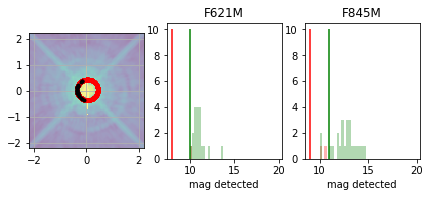

In [232]:
# These test cases are all too red. Might be better to get close ot real distribution of sources.

fig, axes = plot_fakeresults('r10.0_')

m_621:  8.00 and m_845:  9.00 gives detection fraction  0.01
m_621: 10.00 and m_845: 11.00 gives detection fraction  0.13
m_621: 12.00 and m_845: 13.00 gives detection fraction  0.17
m_621: 14.00 and m_845: 15.00 gives detection fraction  0.04
m_621: 16.00 and m_845: 17.00 gives detection fraction  0.00
No sources found
No sources found


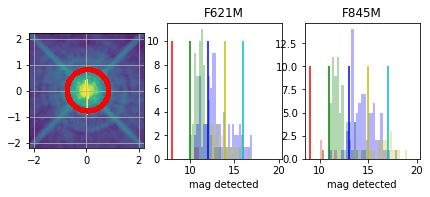

In [233]:
fig, axes = plot_fakeresults('r20.0_')

m_621:  8.00 and m_845:  9.00 gives detection fraction  0.28
m_621: 10.00 and m_845: 11.00 gives detection fraction  0.58
m_621: 12.00 and m_845: 13.00 gives detection fraction  0.52
m_621: 14.00 and m_845: 15.00 gives detection fraction  0.24
m_621: 16.00 and m_845: 17.00 gives detection fraction  0.09
m_621: 18.00 and m_845: 19.00 gives detection fraction  0.00
No sources found


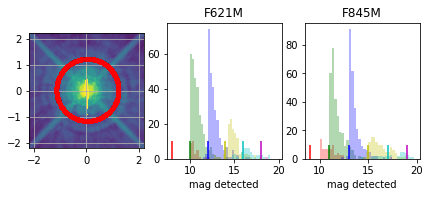

In [234]:
fig, axes = plot_fakeresults('r30.0_')

m_621:  8.00 and m_845:  9.00 gives detection fraction  0.41
m_621: 10.00 and m_845: 11.00 gives detection fraction  0.67
m_621: 12.00 and m_845: 13.00 gives detection fraction  0.75
m_621: 14.00 and m_845: 15.00 gives detection fraction  0.53
m_621: 16.00 and m_845: 17.00 gives detection fraction  0.22
m_621: 18.00 and m_845: 19.00 gives detection fraction  0.02
No sources found


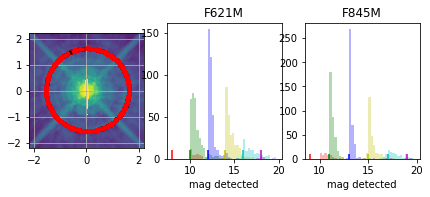

In [235]:
fig, axes = plot_fakeresults('r40.0_')

m_621:  8.00 and m_845:  9.00 gives detection fraction  0.55
m_621: 10.00 and m_845: 11.00 gives detection fraction  0.71
m_621: 12.00 and m_845: 13.00 gives detection fraction  0.75
m_621: 14.00 and m_845: 15.00 gives detection fraction  0.68
m_621: 16.00 and m_845: 17.00 gives detection fraction  0.40
m_621: 18.00 and m_845: 19.00 gives detection fraction  0.06
m_621: 20.00 and m_845: 21.00 gives detection fraction  0.00


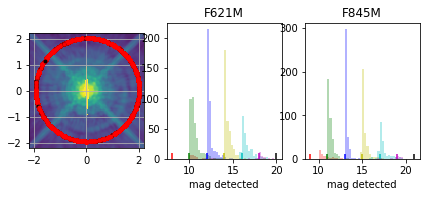

In [238]:
fig, axes = plot_fakeresults('r50.0_')

The highest rate of detected sources is often around $m_V=12$. For real data, any companions brighter than that will be saturated themselves (e.g. V695 Cen) so there is little need to push the simulations to work better in these circumstances. Saturation is not part of the fake insert simulations, but there are other effects that limit the use of this tool for bright sources: We perform a fake insertion using a randomly selected source from a list of real sources. Those real sources are selected from the same exposures as the Cepheids, selecting point sources at some distance from the Cepheid, such that they are not affected by the Cepheid's PSF. We use a set of 13 bright, but not saturated sources and extract a square 25 pixels wide centered on those sources. To insert a fake source close to a Cepheid all pixel values in the selected square are scaled such that the sum of all pixel values corresponds to the flux that the inserted fake source shall have. This scaled image is then simply added to the selected Cepheid at the correct location. 
This approach works for simulating faint sources, but leads to artifacts when the simulated source is required to be brighter than the source used as observed template. In particular, the flux at the edges of inserted templates is not exactly zero. Together with the scaled up noise, this makes the edges inserted square clearly visible and confuses the source detection algorithm for too bright fake sources.

In [317]:
detectfrac = np.zeros((6, 7), dtype=float)
maxdist = 5

for ind_r in range(1, 6):
    for ind_f in range(0, 7):
        filename = fakedir + 'r{}0.0_{}_phot.fits'.format(ind_r, ind_f)
        if os.path.exists(filename):
            phot = Table.read(fakedir + 'r{}0.0_{}_phot.fits'.format(ind_r, ind_f))
            phot['dist'] = np.sqrt((phot['x_621'] - phot['xin'])**2 + (phot['y_621'] - phot['yin'])**2)
            photvalid = (phot['dist'] < maxdist) & np.isfinite(phot['mag_621']) & np.isfinite(phot['mag_845'])
            phot = phot[photvalid]
            # phot can have two entries for the same source in the same image if the source
            # was initially found in both bands
            # For the real data, we do the merging by hand, but here we need code to do that
            temp, ind = np.unique(phot['TARGNAME'], return_index=True)
            detectfrac[ind_r, ind_f] = len(phot[ind]) / phot.meta['N_RUNS']

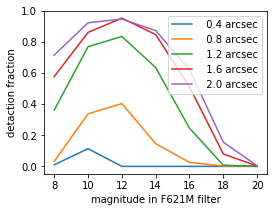

In [319]:
fig, ax = plt.subplots(figsize=(4,3))
mags = [8, 10, 12, 14, 16, 18, 20]

for i in range(1, 6):
    ax.plot(mags, detectfrac[i, 0:], label='{:5.1f} arcsec'.format(i * 10 * pixsize))

ax.legend()
ax.set_ylabel('detaction fraction')
ax.set_xlabel('magnitude in F621M filter')

fig.savefig('../detectlim.ps', bbox_inches='tight')
fig.savefig('../detectlim.pdf', bbox_inches='tight')
fig.savefig('../detectlim.png', bbox_inches='tight')

Text(0.5, 1.0, '2.5')

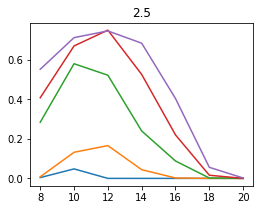

In [301]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(1, 6):
    ax.plot(mags, detectfrac[i, 0:], label='{:5.1f} arcsec'.format(i * 10 * pixsize))
ax.set_title(maxdist)

Text(0.5, 1.0, '5')

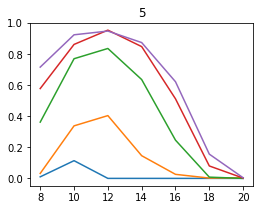

In [303]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(1, 6):
    ax.plot(mags, detectfrac[i, 0:], label='{:5.1f} arcsec'.format(i * 10 * pixsize))
ax.set_title(maxdist)

(array([ 25., 108., 192., 173.,  55.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

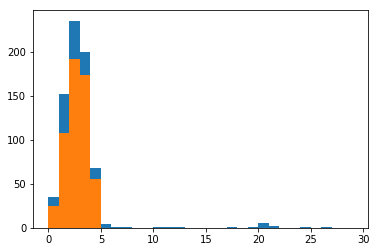

In [326]:
filename = fakedir + 'r{}0.0_{}_phot.fits'.format(3, 3)
if os.path.exists(filename):
    phot = Table.read(filename)
    phot['dist'] = np.sqrt((phot['x_621'] - phot['xin'])**2 + (phot['y_621'] - phot['yin'])**2)
    photvalid = (phot['dist'] < maxdist) & np.isfinite(phot['mag_621']) & np.isfinite(phot['mag_845'])
    
plt.hist(phot['dist'], bins=np.arange(0,30, 1))
plt.hist(phot['dist'][photvalid], bins=np.arange(0,30, 1))

(array([  4.,  52., 214., 248., 107.,  56.,  17.,   1.,   0.]),
 array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4]),
 <a list of 9 Patch objects>)

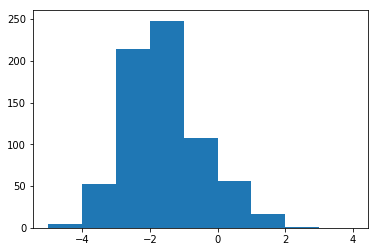

In [328]:
plt.hist(phot['x_621'] - phot['xin'], bins=np.arange(-5, 5))

In [321]:
phot

<Table length=768>
TARGNAME       y_621        ...       f845in               dist       
 bytes8       float64       ...      float64             float64      
-------- ------------------ ... ------------------ -------------------
  FAKE_0  58.81106299712597 ... 515655.91045091324 0.43720643906442713
  FAKE_0 58.867961899694194 ... 515655.91045091324 0.06038313921995621
  FAKE_1  63.10346051601113 ... 515655.91045091324   2.786412741267482
  FAKE_1 63.101360100252606 ... 515655.91045091324   2.788316321008811
  FAKE_2  61.36609408558301 ... 515655.91045091324  3.3404154664674017
  FAKE_2  61.62662760771084 ... 515655.91045091324  3.7511790748896163
  FAKE_3  78.50257502674818 ... 515655.91045091324   3.054117342802534
  FAKE_3  78.28897980268121 ... 515655.91045091324    4.02780564352005
  FAKE_4   76.3508317712056 ... 515655.91045091324    3.61496295848539
  FAKE_4  79.86144132423262 ... 515655.91045091324   3.129025478443688
     ...                ... ...                ...                 ...
FAKE_493  40.68485918786683 ... 515655.91045091324  3.6369933393078524
FAKE_493  40.86933931133609 ... 515655.91045091324   4.245613510463806
FAKE_494  78.82532507967822 ... 515655.91045091324   2.036458943636437
FAKE_495  67.81046710772206 ... 515655.91045091324  3.5487742820065624
FAKE_495  67.94744033429052 ... 515655.91045091324  3.4119996012261438
FAKE_496 42.787820880910274 ... 515655.91045091324   1.890078354108814
FAKE_496  43.80383639153079 ... 515655.91045091324  1.8600910511448567
FAKE_497 52.098809821909065 ... 515655.91045091324   3.981124026898921
FAKE_497 52.020005651342586 ... 515655.91045091324   4.284559350593582
FAKE_498  76.22711496075026 ... 515655.91045091324  1.3382465173605473

## Source detection
Now that the Cepheids are subtracted, we can start to detect the remaining sources in the images.
In principle, this needs to be done iteratively. If I know detect a source that was not part of the initial (preliminary) source list, that means that a new regions in one of the images will have to be masked for optimization purposes and then the fit will have to be run again. I'll see if that actually happens.

### 

From this list the following sources will be missing - they have to be added back in by hand:

- compagion of eta Aql
- compagnion of V659 Cen

In these stars, the binary partners are themselves saturated. Thus the peaks fall on a masked region and are not output in the list.

In [77]:
ind = F621names.index('AV-CIR')

data = reduced_images845[:, :, ind]
#data = normF621[:, :, ind]
daofind = DAOStarFinder(fwhm=2.5, threshold=.1*np.std(data), sharplo=0.0, sharphi=1., roundlo=-1., roundhi=1.)    
test_band1 = daofind(data, mask=data.mask)
#data = normF845[:, :, ind]
#daofind = DAOStarFinder(fwhm=2.5, threshold=5.*np.std(data), sharplo=0.55, sharphi=.75, roundlo=-0.6, roundhi=0.6)    
#test_band2 = daofind(data, mask=data.mask)

test_band1

NameError: name 'DAOStarFinder' is not defined

NameError: name 'test_band1' is not defined

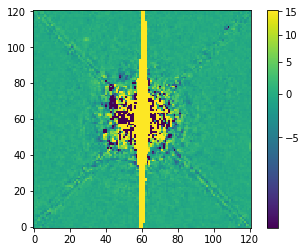

In [78]:


norm = ImageNormalize(data, interval=AsymmetricPercentileInterval(2, 95), stretch=SqrtStretch())
plt.imshow(data, norm=norm, origin='lower')
plt.colorbar()
apertures = photutils.CircularAperture(np.vstack([test_band1['xcentroid'], test_band1['ycentroid']]).T, r=5)
apertures.plot(color='r')

In [ ]:
# Try DAOPhot algorithm
src_F621M_step1 = []
src_F845M_step1 = []

companion_finder = CompanionFinder(fwhm=2.5, threshold=3, sharplo=0.4, sharphi=.8,
                            roundlo=-0.3, roundhi=0.3, exclude_border=True)

for i in range(F621Marr.shape[-1]):
    src_F621M_step1.append(companion_finder(reduced_images621[:, :, i]))
    src_F845M_step1.append(companion_finder(reduced_images845[:, :, i]))
    
sources_step1 = combine_source_tables(src_F621M_step1, src_F845M_step1, F621names, dmax=None, 
                                xname='xcentroid', yname='ycentroid')

In [ ]:
sources_step1_tight = combine_source_tables(src_F621M_step1, src_F845M_step1, F621names, dmax=2, 
                                xname='xcentroid', yname='ycentroid')

In [ ]:
len(sources_step1), len(sources_step1_tight), (sources_initial['filter'] == 'F621M').sum(), \
(sources_initial['filter'] == 'F845M').sum(), (sources_initial['filter'] == 'HAND').sum()

In [ ]:
sources_step1_tight[sources_step1_tight['TARGNAME'] == 'BG-CRU']

In [ ]:
fig, axgrid = plot_gallery(reduced_images621, F621names, 
                           imshow_norm_kwargs={'stretch': visualization.LogStretch(a=10),
                                              'interval': visualization.PercentileInterval(90.)})
add_sources_to_gallery(axgrid, F621names, F621M, sources_step1_tight, 
                       xname='xcentroid', yname='ycentroid', r=5, color='r')
add_sources_to_gallery(axgrid, F621names, F621M, sources_initial[sources_initial['filter'] == 'F621M'], 
                       xname='xcentroid', yname='ycentroid', r=7, color='w')
add_sources_to_gallery(axgrid, F621names, F621M, sources_initial[sources_initial['filter'] == 'F845M'], 
                       xname='xcentroid', yname='ycentroid', r=9, color='b')
add_sources_to_gallery(axgrid, F621names, F621M, sources_initial[sources_initial['filter'] == 'HAND'], 
                       xname='xcentroid', yname='ycentroid', r=11, color='k')

In [ ]:
plt.hist(sources_step1['roundness2'][sources_step1['flux']>2])
plt.hist(sources_step1_tight['roundness2'][sources_step1_tight['flux']>2])

In [ ]:
sources_1 = sources_step1[sources_step1['filter'] == 'F621M']
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
ax.scatter(sources_1['xcentroid'], sources_1['ycentroid'])
ax.scatter(sources_in['xcentroid'], sources_in['ycentroid'])
ax.plot([0, 120], [0, 120], 'k', lw=2) 
ax.plot([0, 120], [120, 0], 'k', lw=2) 
ax.set_xlim([0, 2*halfwidth+1])
ax.set_ylim([0, 2*halfwidth+1])

#fig.savefig(outdir + )

It is a little suspicious that almost all sources are either on the diffraction spikes or just surrounding the masked region around the bleed column.

Now I could do mroe masking and repeat the PSF subtraction. 

That's still the plan, but I will implement the photometry first and see how many of those sources hold up to fitting.

## Photometry of the sources we found above

In [79]:
# Just to I can play with it below and don't mess up the initial list
sources = sources_initial.copy()
for col in sources.columns:
    if np.issubdtype(sources[col].dtype, np.floating):
        sources[col].format='4.1f'

In [80]:
sources

<Table masked=True length=22>
  id  xcentroid ycentroid sharpness ...   flux    mag   filter TARGNAME
int64  float64   float64   float64  ... float64 float64  str5    str8  
----- --------- --------- --------- ... ------- ------- ------ --------
    1       1.4       1.5       0.7 ...     1.5    -0.5  F845M   AV-CIR
    2      28.9     104.3       0.7 ...     1.8    -0.6  F845M   AV-CIR
    1     116.3       5.4       0.7 ...     3.0    -1.2  F845M   BG-CRU
    1     117.6      19.9       0.7 ...     6.0    -2.0  F621M   CO-AUR
    1     116.5      20.0       0.6 ...     8.1    -2.3  F845M   CO-AUR
    1     118.4       1.1       0.7 ...     1.5    -0.4  F845M   DT-CYG
    1      54.8      43.7       0.6 ...     8.3    -2.3  F845M  ETA-AQL
    1       1.5       1.4       0.7 ...     1.8    -0.6  F621M   FF-AQL
    1      55.1     107.9       0.7 ...     7.8    -2.2  F621M    R-CRU
    1      56.0     107.8       0.6 ...    10.0    -2.5  F845M    R-CRU
    1      36.7      57.4       0.6 ...     9.1    -2.4  F621M    S-NOR
    2      49.9      47.7       0.7 ...     1.4    -0.4  F845M   SU-CAS
    3      69.6      47.7       0.6 ...     2.1    -0.8  F845M   SU-CAS
    1      66.2      20.6       0.6 ...     7.2    -2.1  F621M    U-AQL
    1      65.9      20.9       0.7 ...    12.6    -2.7  F845M    U-AQL
    1      38.4      92.4       0.6 ...     8.6    -2.3  F845M    U-VUL
    1     118.7      10.3       0.7 ...     1.7    -0.6  F621M V636-SCO
    1       1.4       1.6       0.7 ...     1.7    -0.6  F845M V950-SCO
    1       1.2     118.6       0.7 ...     1.6    -0.5  F845M    X-CYG
    1      72.6      69.3       nan ...   100.0     inf   HAND V659-CEN
    1      57.4      68.5       nan ...   100.0     inf   HAND   AX-CIR
    1      54.2      43.7       nan ...   100.0     inf   HAND  ETA-AQL

In [81]:
# Simplify source list by removing dublicate sources
# Impelementation here is not fast, but easy to write down
#src_targ = sources.group_by('TARGNAME')
# Loop over all targets
#for g in src_targ.groups:
#    for row in g
srctofit = sources[[1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20]]
srctofit

<Table masked=True length=17>
  id  xcentroid ycentroid sharpness ...   flux    mag   filter TARGNAME
int64  float64   float64   float64  ... float64 float64  str5    str8  
----- --------- --------- --------- ... ------- ------- ------ --------
    2      28.9     104.3       0.7 ...     1.8    -0.6  F845M   AV-CIR
    1     116.3       5.4       0.7 ...     3.0    -1.2  F845M   BG-CRU
    1     117.6      19.9       0.7 ...     6.0    -2.0  F621M   CO-AUR
    1     118.4       1.1       0.7 ...     1.5    -0.4  F845M   DT-CYG
    1      54.8      43.7       0.6 ...     8.3    -2.3  F845M  ETA-AQL
    1       1.5       1.4       0.7 ...     1.8    -0.6  F621M   FF-AQL
    1      55.1     107.9       0.7 ...     7.8    -2.2  F621M    R-CRU
    1      36.7      57.4       0.6 ...     9.1    -2.4  F621M    S-NOR
    2      49.9      47.7       0.7 ...     1.4    -0.4  F845M   SU-CAS
    3      69.6      47.7       0.6 ...     2.1    -0.8  F845M   SU-CAS
    1      66.2      20.6       0.6 ...     7.2    -2.1  F621M    U-AQL
    1      38.4      92.4       0.6 ...     8.6    -2.3  F845M    U-VUL
    1     118.7      10.3       0.7 ...     1.7    -0.6  F621M V636-SCO
    1       1.4       1.6       0.7 ...     1.7    -0.6  F845M V950-SCO
    1       1.2     118.6       0.7 ...     1.6    -0.5  F845M    X-CYG
    1      72.6      69.3       nan ...   100.0     inf   HAND V659-CEN
    1      57.4      68.5       nan ...   100.0     inf   HAND   AX-CIR

In [82]:
def plot_subtracted(F621Marr, F845Marr, reduced_images621, reduced_images845, indexname, out):
    i = indexname(out['TARGNAME'])
    fig, ax = plt.subplots(2, 4, figsize=(15, 8))

    norm = ImageNormalize(stretch=SqrtStretch(), vmin=-100, vmax=5000, clip=False)
    palette = copy.copy(plt.cm.viridis)
    palette.set_bad('w', 1.0)
    imshowkwargs = {'interpolation': 'none', 'origin': 'lower', 'cmap': palette}
    aper_in = photutils.CircularAperture((out['x_0'][0], out['y_0'][0]), r=3)
    aper_621 = photutils.CircularAperture((out['x_621'][0], out['y_621'][0]), r=3)
    aper_845 = photutils.CircularAperture((out['x_845'][0], out['y_845'][0]), r=3)
    

    for j, data, redim, resim in [(0, F621Marr[:, :, i], reduced_images621[:, :, i], 
                                   out['residual_image_621'].data.squeeze()),
                                  (1, F845Marr[:, :, i], reduced_images845[:, :, i], 
                                   out['residual_image_845'].data.squeeze())]:
        im = ax[j, 0].imshow(data, norm=norm, **imshowkwargs)
        plt.colorbar(im, ax=ax[j, 0], extend='both')

        im = ax[j, 1].imshow(redim, norm=norm, **imshowkwargs)
        plt.colorbar(im, ax=ax[j, 1], extend='both')

        # determine zoom range for image zoomed in on compagnion
        slices_large, slices_small = overlap_slices(redim.shape, (10, 10), (out['y_0'][0], out['x_0'][0]))
        dat = redim[slices_large]
        normzoom = ImageNormalize(stretch=SqrtStretch(), vmin=dat.min(), vmax=dat.max(), clip=False)

        im = ax[j, 2].imshow(redim, norm=normzoom, **imshowkwargs)
        plt.colorbar(im, ax=ax[j,2], extend='both')
        mark_inset(ax[j, 1], ax[j,2], loc1=2, loc2=3, fc="none", ec="0.5")
    
        im = ax[j, 3].imshow(resim, norm=normzoom, **imshowkwargs)
        plt.colorbar(im, ax=ax[j, 3], extend='both')

    for j, k in [(0, 2), (0, 3), (1, 2), (1, 3)]:
        ax[j, k].set_xlim([out['x_0'][0]-10, out['x_0'][0]+11])
        ax[j, k].set_ylim([out['y_0'][0]-10, out['y_0'][0]+11])
        
    for a in ax.flatten():
        aper_in.plot(ax=a, color='k')
        aper_621.plot(ax=a, color='b')
        aper_845.plot(ax=a, color='r')

    ax[0, 0].set_title('Original image')
    ax[0, 1].set_title('Cepheid removed')
    ax[0, 2].set_title('Cepheid removed')
    ax[0, 3].set_title('Compagnion removed')
    ax[0, 0].set_ylabel('F621M')
    ax[1, 0].set_ylabel('F845M')
    fig.suptitle(out['TARGNAME'][0])
    return fig, ax

### Check PSF magnitudes
We do a fairly involved processing with normalizing and median-normalizing the image, fitting and normalizing the PSF, finding sources, Cepheid subtraction etc. . There are several places where things can go wrong, so we just need to test that the magnitudes that we measure are real. To this end, we compare to the magnitudes of sources that are far from the Cepheid and that were reduced with much simpler processing in the second paper of the series.

Nancy selected the following for a good comparison:
- Source close to: R Cru
- F621M: 15.71  $\pm$ 0.02
- F621-F845: .77 $\pm$   0.03
- ang sep: 42"
- coordinates of test star: 12 23 36.7 -61 37 41.1

Since this source is pretty far form the Cepheid (Hey, we wanted to test this on a source that is not in the PSF) we need to do the reading and cutting of the input image by hand.

In [83]:
rcrufiles = fitslist.files_filtered(TARGNAME='R-CRU')

In [84]:
test621 = extract_stars(NDData(fits.open(datadir + rcrufiles[0])[1].data), Table({'x':[647], 'y': [696]}))
test845 = extract_stars(NDData(fits.open(datadir + rcrufiles[1])[1].data), Table({'x':[647], 'y': [696]}))

In [85]:
testF621Marr, testF621M = read_images(fitslist.files_filtered(FILTER='F621M', TARGNAME='R-CRU', 
                                                              include_path=True), halfwidth=500)
testF845Marr, testF845M = read_images(fitslist.files_filtered(FILTER='F845M', TARGNAME='R-CRU',
                                                              include_path=True), halfwidth=500)

working on file 0
working on file 0


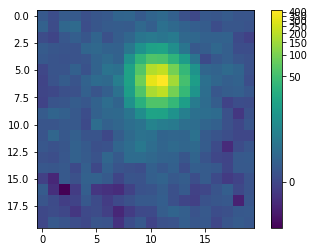

In [86]:
out = imshow_norm(testF621Marr[650:670, 605: 625, 0], stretch=LogStretch())
plt.colorbar()
# Determine position of source by hand as a starting point for the fit below: 656, 616

In [87]:
outtab = phot_sherpa(testF621Marr, testF845Marr, lambda x: 0, 
                    {'TARGNAME':'R-CRU', 'xcentroid': 616., 'ycentroid': 655.8}, 
                     psf_621, psf_845, slice_size=11)

In [88]:
outtab

<Table masked=True length=1>
TARGNAME       y_621       ...        residual_image_845 [1001,1001]       
  str5        float64      ...                   float64                   
-------- ----------------- ... --------------------------------------------
   R-CRU 655.9957539924566 ... -0.22546041282581558 .. -0.41819050452282697

The fitted magnitudes match the magnitudes given to me by Nancy very well. While the test in the cells above does not go through the entire chain of data reduction that I use for the Cepheid companions, it does test that the PSF model is normalized properly and that the formulas to convert from fitted amplitudes to magnitudes are consistent.

### Photometry of the sources we find close to Cepheids

In [116]:
F621names.index('BG-CRU')

9

In [89]:
allout = []
for r in srctofit:
    out = phot_sherpa(reduced_images621, reduced_images845, F621names.index, r, psf_621, psf_845,
                     stat=sherpa.stats.LeastSq())
    allout.append(out)

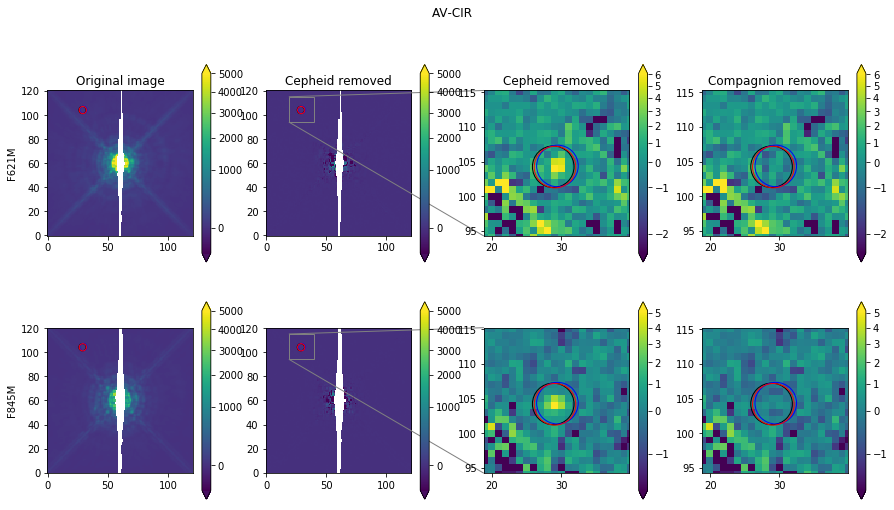

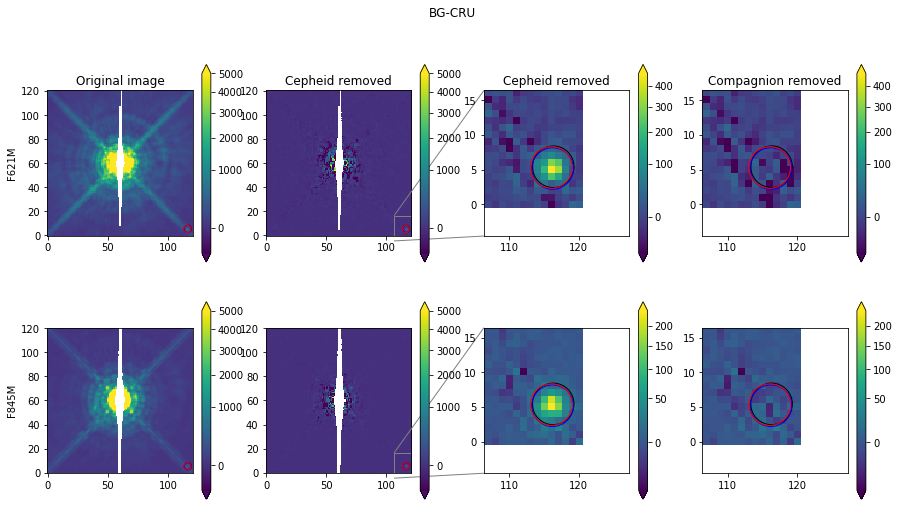

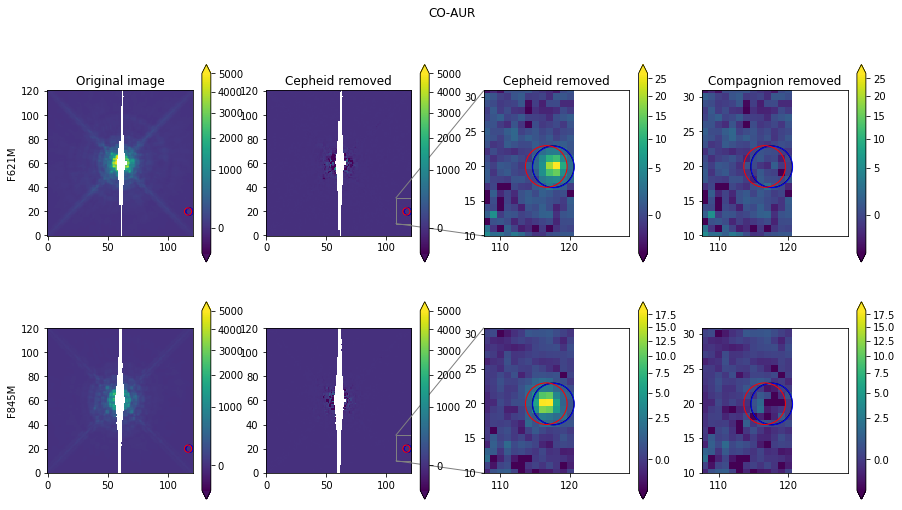

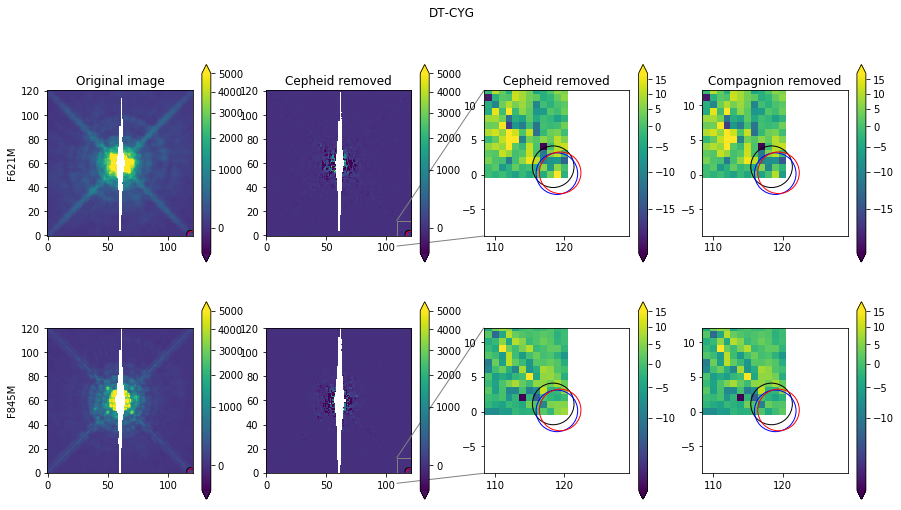

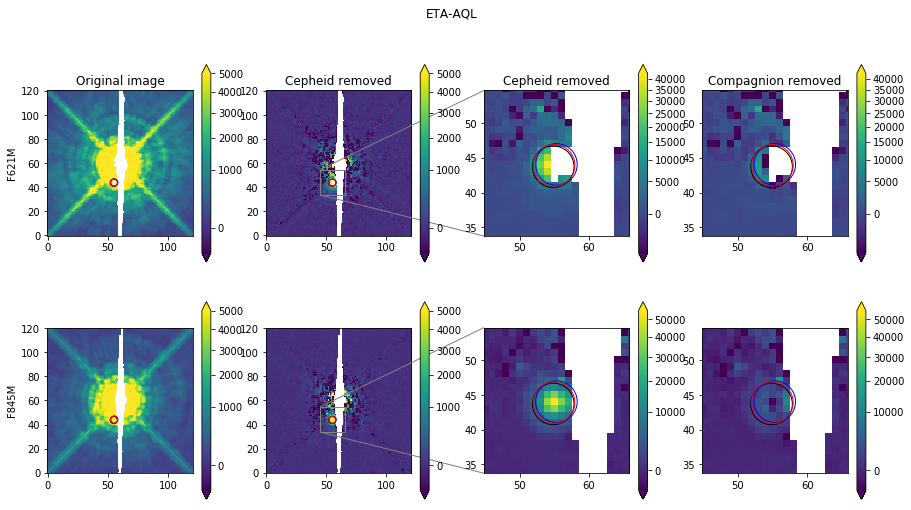

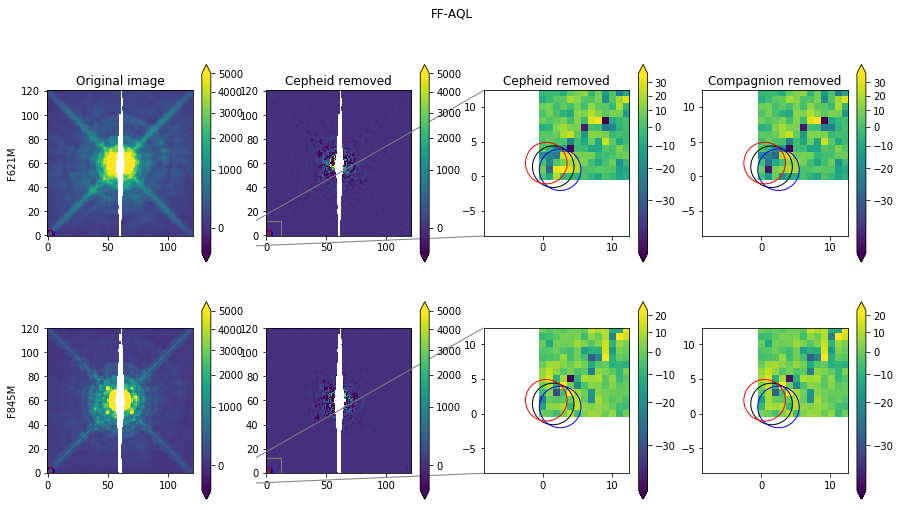

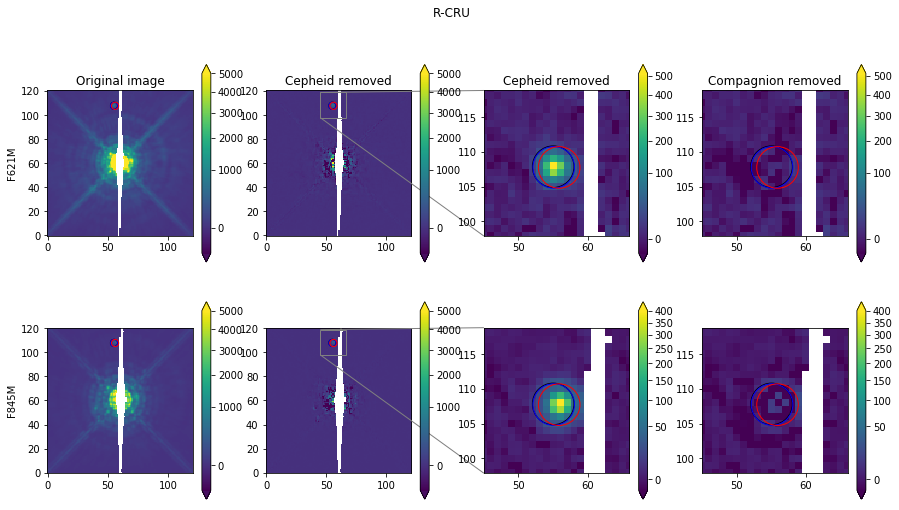

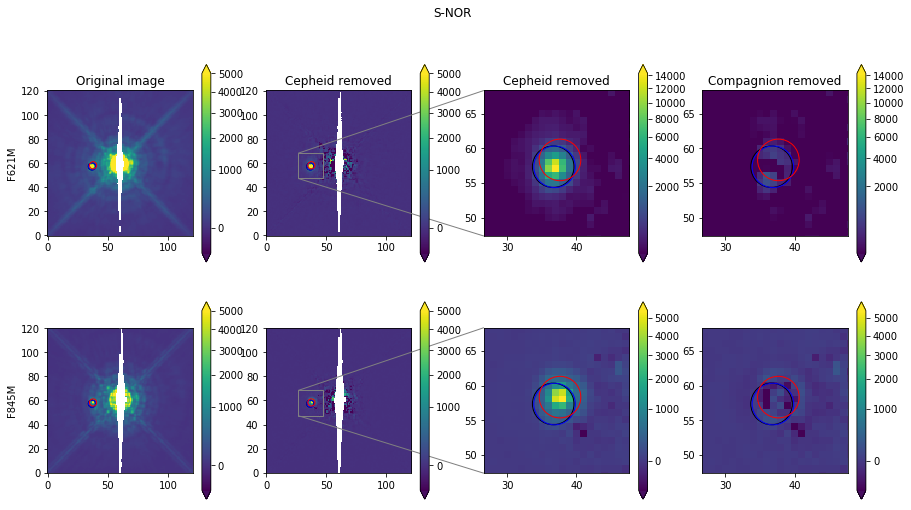

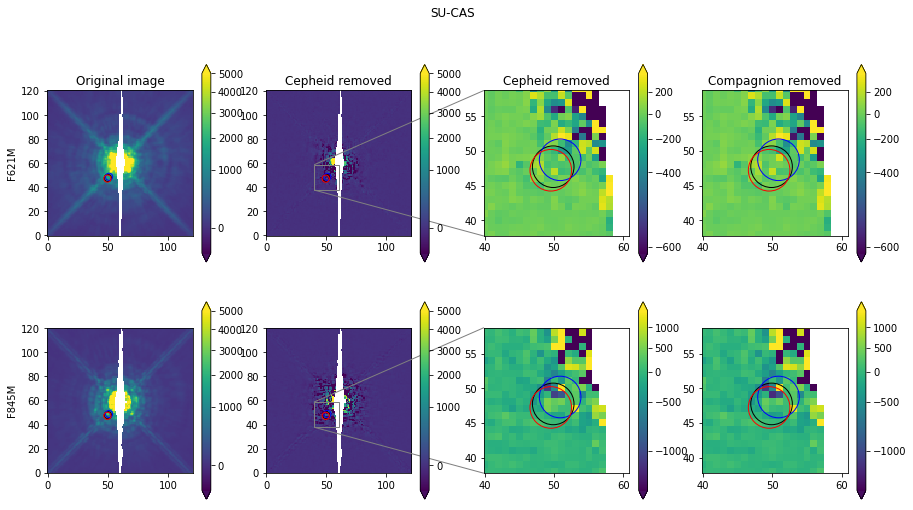

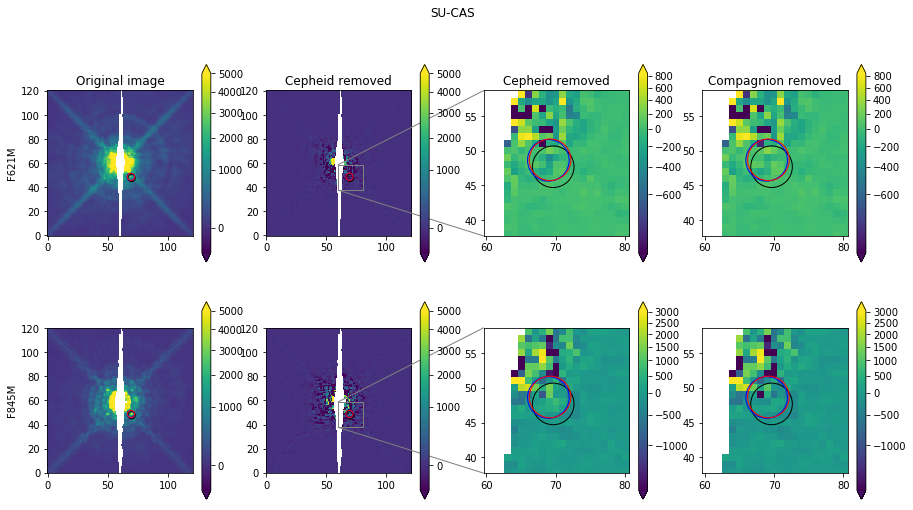

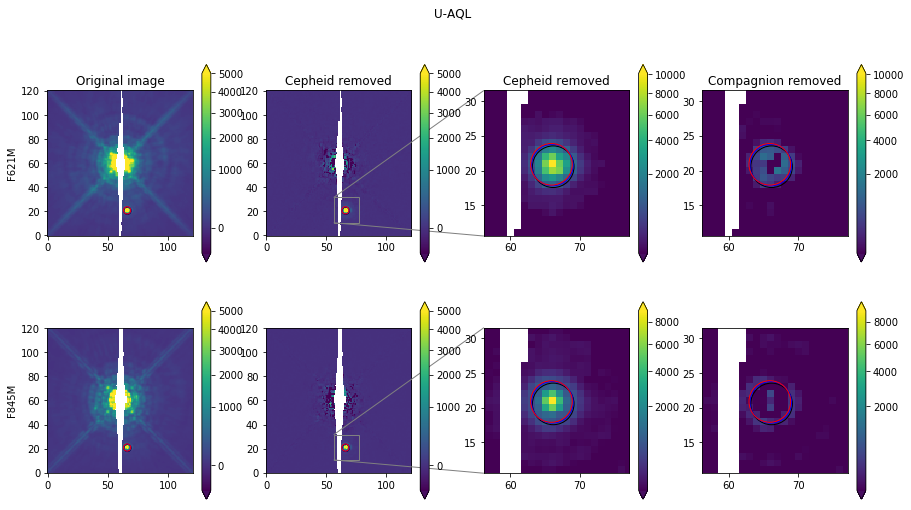

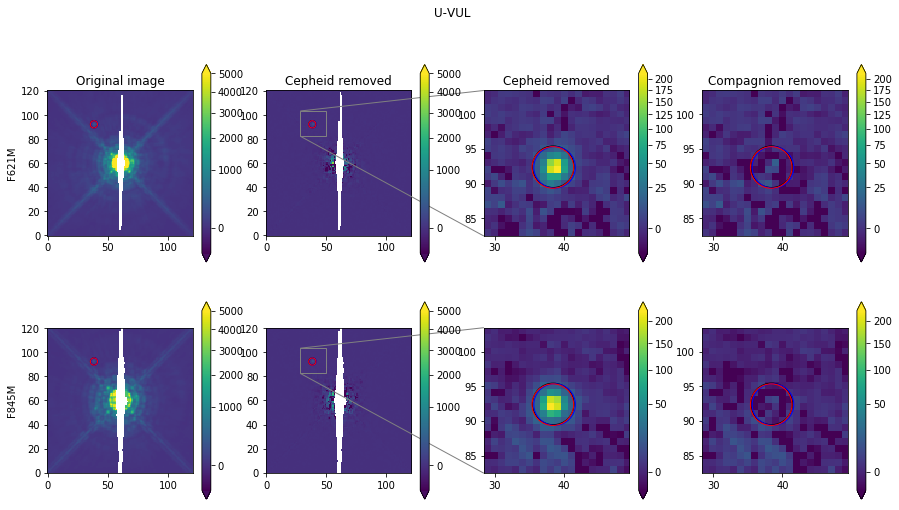

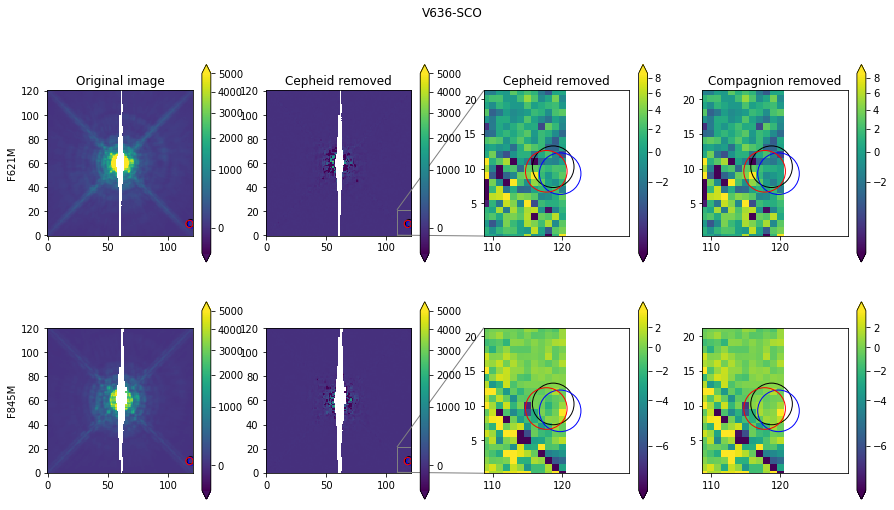

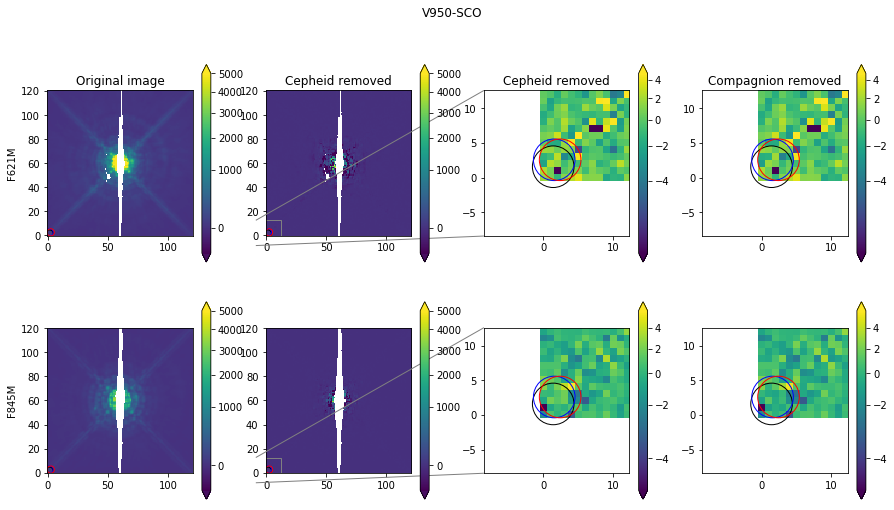

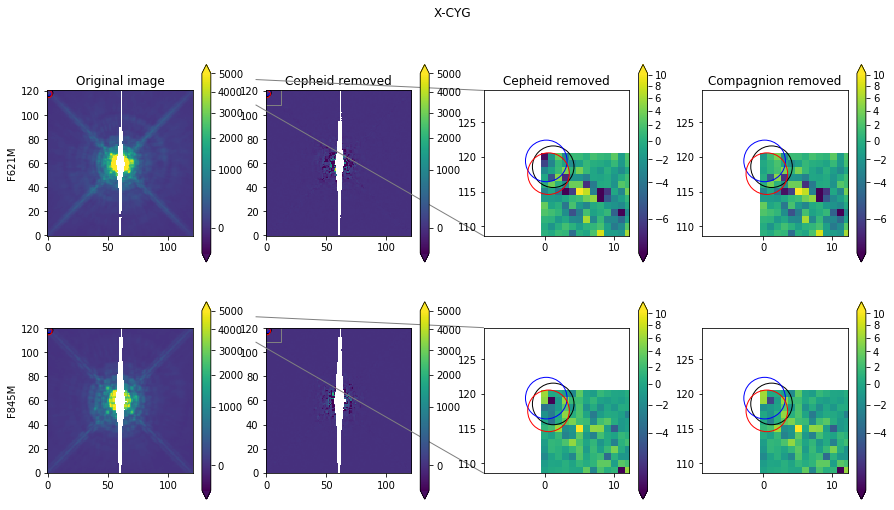

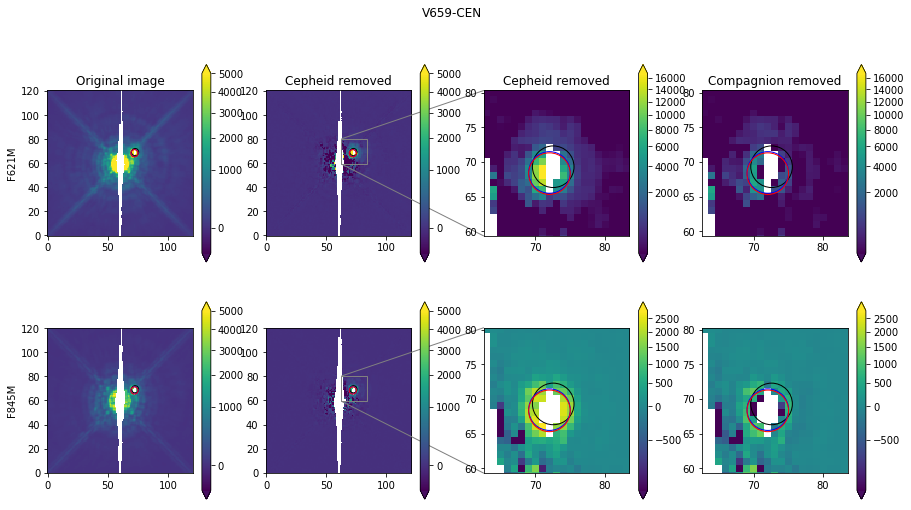

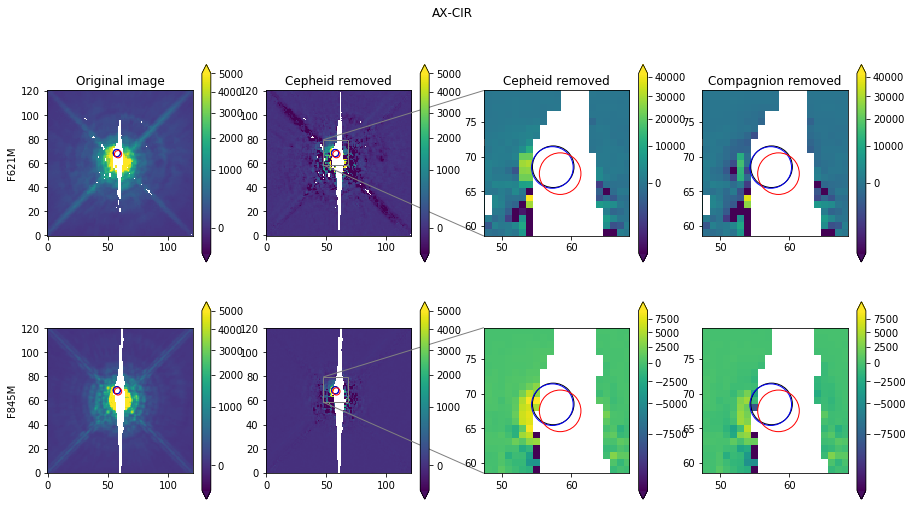

In [90]:
for r in allout:
    fig, ax = plot_subtracted(F621Marr, F845Marr, reduced_images621, reduced_images845, F621names.index, r)

The fit does not work for AX Cir because the companion is so bright and so close to the central star, that almost the entire region is masked as bad. The fit thus can be done solely on the wings that "stick out" under the mask. This is problematic for three reasons: 
- We have only a very small valid area for the fit.
- The PSF in the wings is not well known. We know that our analytic PSF model is not very good there (partially because we don't have bright stars to make the model in the first place and partially because our analytic function just does not describe the wings well. After all, that's why we do all this effort for the Cepheids.
- The lower part of the few valid pixels overlaps with strong, but unavoidable residuals from the Cepheid.

In [91]:
def add_sep_posang(tab, names, coords1, coords2):
    '''Add separation and position angle between Cepheid and companion to a list of companions
    
    Because the WCS between the two filters can differ slightly and also to fit to the position
    is done independently (within some limits) in the two bands, the derived separation and 
    PA can differ slightly between the two bands. This routine just calcualtes the simple mean
    with no error propagation since in practice, errors are probably dominated by systematics
    from the Cepheid subtration and not by the statistical errors of the fit.
    '''
    sep = []
    posang = []
    
    for row in tab:
        i = names.index(row['TARGNAME'])    
        # Filter F621M
        c = coords1[i]
        cepheid = SkyCoord(*c.wcs.all_pix2world(halfwidth, halfwidth, 0), unit='deg')
        companion = SkyCoord(*c.wcs.all_pix2world(row['x_621'], row['y_621'], 0), unit='deg')
        sep1 = cepheid.separation(companion).arcsec
        posang1 = cepheid.position_angle(companion).degree
    
        # Filter F845M
        c = coords2[i]
        cepheid = SkyCoord(*c.wcs.all_pix2world(halfwidth, halfwidth, 0), unit='deg')
        companion = SkyCoord(*c.wcs.all_pix2world(row['x_845'], row['y_845'], 0), unit='deg')
        sep2 = cepheid.separation(companion).arcsec
        posang2 = cepheid.position_angle(companion).degree

        # Appending to lists might be slower than having a numpy array of known size,
        # but speed will never be a concern for this
        sep.append(np.mean([sep1, sep2]))
        posang.append(np.mean([posang1, posang2]))
    tab['separation'] = sep
    tab['separation'].unit = u.arcsec
    tab['P.A. (E of N)'] = posang
    tab['P.A. (E of N)'].unit = u.degree

In [96]:
outtab = table.vstack(allout)

add_sep_posang(outtab, F621names, F621M, F845M)

outtab['mag_621'].unit = u.mag
outtab['mag_845'].unit = u.mag

for col in outtab.columns:
    if np.issubdtype(outtab[col].dtype, np.floating):
        outtab[col].format='4.1f'
        
outtab['TARGNAME', 'mag_621', 'mag_845', 'separation', 'P.A. (E of N)']

<Table masked=True length=17>
TARGNAME mag_621 mag_845 separation P.A. (E of N)
           mag     mag     arcsec        deg     
  str8   float64 float64  float64      float64   
-------- ------- ------- ---------- -------------
  AV-CIR    20.1    19.2        2.1         288.5
  BG-CRU    15.5    14.9        3.1         294.8
  CO-AUR    18.6    17.7        2.8           8.8
  DT-CYG    20.1    18.9        3.3         148.1
 ETA-AQL     9.3     8.9        0.7          95.7
  FF-AQL    18.7     nan        3.3          74.2
   R-CRU    15.4    14.4        1.9         344.5
   S-NOR    11.7    11.5        0.9         259.2
  SU-CAS     nan    14.9        0.6         213.8
  SU-CAS     nan    13.6        0.6         291.6
   U-AQL    12.0    11.1        1.6         225.1
   U-VUL    16.3    14.9        1.5         319.7
V636-SCO    21.0     nan        3.1         184.3
V950-SCO    22.2    20.0        3.2         291.4
   X-CYG     nan     nan        3.3          29.8
V659-CEN    10.5    10.1        0.6         234.9
  AX-CIR     7.2     7.0        0.3         332.4

In [345]:
outtab.colnames

['TARGNAME',
 'y_621',
 'x_621',
 'y_845',
 'x_845',
 'mag_621',
 'mag_845',
 'x_0',
 'y_0',
 'residual_image_621',
 'residual_image_845',
 'separation',
 'P.A. (E of N)']

In [139]:
flux2mag(2e3, 'F621M'), flux2mag(2.7e3, 'F845M')

(16.201325010840048, 14.702490589602531)

        None       
-------------------
-1.2096868530408549


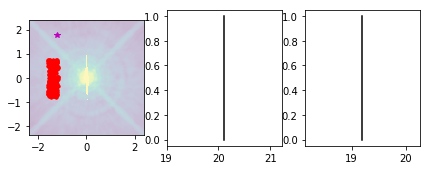

In [372]:
name = 'AV-CIR'
fig, axes = plot_fakeresults(name, binsize=.1, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
#axes[1].set_xlim([15, 16.5])
#axes[2].set_xlim([14, 16])

m_621: 15.10 and m_845: 14.70 gives detection fraction  0.30
       None      
-----------------
2.227393114968984


(14, 16)

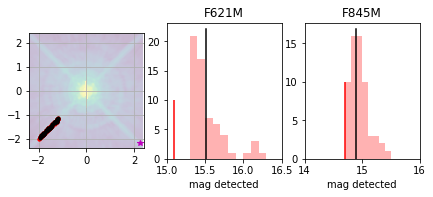

In [373]:
name = 'BG-CRU'
fig, axes = plot_fakeresults(name, binsize=.1, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
axes[1].set_xlim([15, 16.5])
axes[2].set_xlim([14, 16])

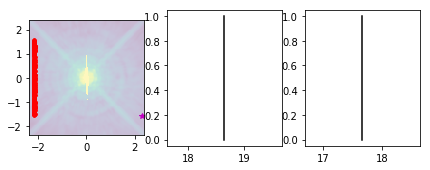

In [375]:
name = 'CO-AUR'
fig, axes = plot_fakeresults(name, binsize=.1, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
#axes[1].set_xlim([15, 16.5])
#axes[2].set_xlim([14, 16])

m_621: 15.33 and m_845: 14.34 gives detection fraction  0.92


(14, 16)

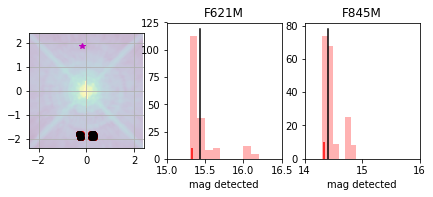

In [376]:
name = 'R-CRU'
fig, axes = plot_fakeresults(name, binsize=.1, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
axes[1].set_xlim([15, 16.5])
axes[2].set_xlim([14, 16])

m_621: 11.40 and m_845: 11.20 gives detection fraction  0.59


(11, 13)

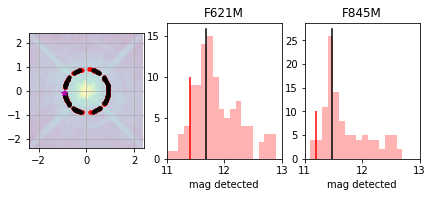

In [380]:
name = 'S-NOR'
fig, axes = plot_fakeresults(name, binsize=.1, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
axes[1].set_xlim([11, 13])
axes[2].set_xlim([11, 13])

m_621: 11.87 and m_845: 11.00 gives detection fraction  0.92


(10.5, 12)

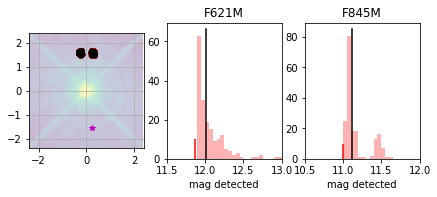

In [378]:
name = 'U-AQL'
fig, axes = plot_fakeresults(name, binsize=.05, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
axes[1].set_xlim([11.5, 13])
axes[2].set_xlim([10.5, 12])

m_621: 16.20 and m_845: 14.80 gives detection fraction  0.93


(14, 16)

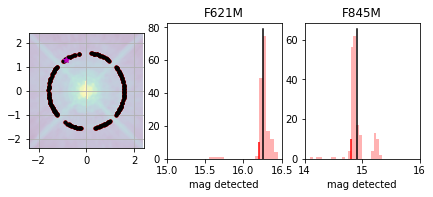

In [379]:
name = 'U-VUL'
fig, axes = plot_fakeresults(name, binsize=.05, target=name, table=outtab)
row = outtab[outtab['TARGNAME'] == name]
axes[1].plot([row['mag_621'], row['mag_621']], axes[1].get_ylim(), 'k')
axes[2].plot([row['mag_845'], row['mag_845']], axes[2].get_ylim(), 'k')
axes[1].set_xlim([15, 16.5])
axes[2].set_xlim([14, 16])

## Image for proposal

In [ ]:
from astropy.visualization import ZScaleInterval

i = F621names.index('V473-LYR')

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121, projection=F621M[i].wcs)
norm = ImageNormalize(F621Marr[:, :, i], interval=ZScaleInterval(),
                      #stretch=LogStretch()
                     )
norm = ImageNormalize(stretch=SqrtStretch(), vmin=-100, vmax=1000)
im1 = ax1.imshow(F621Marr[:, :, i], interpolation='none', norm=norm)
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(122, projection=F621M[i].wcs)
im2 = ax2.imshow(reduced_images621[:, :, i].data, interpolation='none', norm=norm)
plt.colorbar(im2, ax=ax2)

for ax in [ax1, ax2]:
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    ra.grid(color='w', linestyle='solid', linewidth=1)
    dec.grid(color='w', linestyle='solid', linewidth=1)
    ra.set_major_formatter('hh:mm:ss.s')

fig.subplots_adjust(left=.2)
fig.savefig('../V473-Lyr.ps', bbox_inches='tight')
fig.savefig('../V473-Lyr.pdf', bbox_inches='tight')
fig.savefig('../V473-Lyr.png', bbox_inches='tight')

In [ ]:
from astropy.visualization import ZScaleInterval

i = F621names.index('V473-LYR')

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121, projection=F621M[i].wcs)
norm = ImageNormalize(F621Marr[:, :, i], interval=ZScaleInterval(),
                      #stretch=LogStretch()
                     )
norm = ImageNormalize(stretch=SqrtStretch(), vmin=-100, vmax=1000)
im1 = ax1.imshow(F621Marr[:, :, i], interpolation='none', norm=norm)
plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(122, projection=F621M[i].wcs)
im2 = ax2.imshow(reduced_images621[:, :, i].data, interpolation='none', norm=norm)
plt.colorbar(im2, ax=ax2)

for ax in [ax1, ax2]:
    ra = ax.coords['ra']
    dec = ax.coords['dec']
    #ra.grid(color='w', linestyle='solid', linewidth=1)
    #dec.grid(color='w', linestyle='solid', linewidth=1)
    ra.set_major_formatter('hh:mm:ss.s')

fig.subplots_adjust(left=.2)
fig.savefig('../V473-Lyr_1.ps', bbox_inches='tight')
fig.savefig('../V473-Lyr_1.pdf', bbox_inches='tight')
fig.savefig('../V473-Lyr_1.png', bbox_inches='tight')

In [ ]:
mwcs = F621M[i].wcs
np.sqrt(1.0469335746174e-05**2+3.3934153052277e-06**2)*3600, np.sqrt(3.3934153052277e-06**2+1.04693357461742e-05**2)*3600

In [ ]:
arrowtip_pix = [10, 10]
arrowtip_world = mwcs.all_pix2world(*arrowtip_pix, 0)
arrowbase_pix = mwcs.all_world2pix(arrowtip_world[0] - 1e-4, arrowtip_world[1], 0)


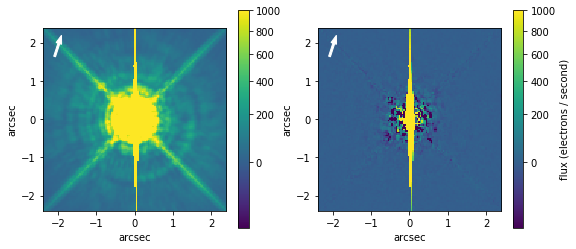

In [292]:
from astropy.visualization import ZScaleInterval

i = F621names.index('V473-LYR')
mwcs = F621M[i].wcs


fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
norm = ImageNormalize(F621Marr[:, :, i], interval=ZScaleInterval(),
                      #stretch=LogStretch(),
                     )
norm = ImageNormalize(stretch=SqrtStretch(), vmin=-100, vmax=1000)
im1 = ax1.imshow(F621Marr[:, :, i], interpolation='none', norm=norm,
                 extent=np.array([-1,1,-1,1]) * (halfwidth +0.5) * pixsize)



cbar1 = plt.colorbar(im1, ax=ax1)

ax2 = fig.add_subplot(122)
im2 = ax2.imshow(reduced_images621[:, :, i].data, interpolation='none', norm=norm,
                 extent=np.array([-1,1,-1,1]) * (halfwidth +0.5) * pixsize)
cbar2 = plt.colorbar(im2, ax=ax2)
cbar2.set_label('flux (electrons / second)')

arrowtip_pix = [-50, 50]
arrowtip_world = mwcs.all_pix2world(*arrowtip_pix, 0)
arrowbase_pix = mwcs.all_world2pix(arrowtip_world[0], arrowtip_world[1] - 1e-4, 0)  


for ax in [ax1, ax2]:
    ax.set_ylabel('arcsec')
    ax.set_xlabel('arcsec')
    ax.arrow(arrowbase_pix[0] * pixsize,
          arrowbase_pix[1] * pixsize, 
          (- arrowbase_pix[0] + arrowtip_pix[0]) * pixsize,
          (- arrowbase_pix[1] + arrowtip_pix[1]) * pixsize,
         width=.05, color='w')

fig.subplots_adjust(left=.2)
fig.savefig('../V473-Lyr_2.ps', bbox_inches='tight')
fig.savefig('../V473-Lyr_2.pdf', bbox_inches='tight')
fig.savefig('../V473-Lyr_2.png', bbox_inches='tight')

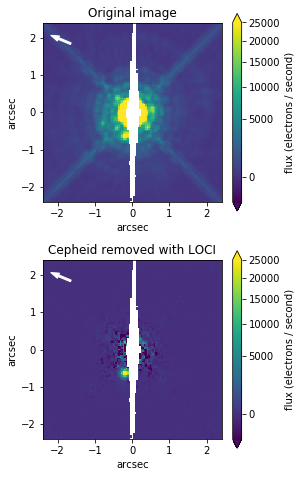

In [344]:

i = F621names.index('ETA-AQL')
fig, ax = plt.subplots(2, 1, figsize=(4, 8))

mwcs = F845M[i].wcs

norm = ImageNormalize(stretch=SqrtStretch(), vmin=-500, vmax=25000, clip=False)
palette = copy.copy(plt.cm.viridis)
palette.set_bad('w', 1.0)
imshowkwargs = {'extent': np.array([-1,1,-1,1]) * (halfwidth +0.5) * pixsize,
    'interpolation': 'none', 'origin': 'lower', 'cmap': palette}
    #aper_in = photutils.CircularAperture((out['x_0'][0], out['y_0'][0]), r=3)
    #aper_621 = photutils.CircularAperture((out['x_621'][0], out['y_621'][0]), r=3)
    #aper_845 = photutils.CircularAperture((out['x_845'][0], out['y_845'][0]), r=3)
    
im = ax[0].imshow(F845Marr[:, :, i], norm=norm, **imshowkwargs)
cbar1 = plt.colorbar(im, ax=ax[0], extend='both')
im = ax[1].imshow(reduced_images845[:, :, i], norm=norm, **imshowkwargs)
cbar2 = plt.colorbar(im, ax=ax[1], extend='both')

ax[0].set_title('Original image')
ax[1].set_title('Cepheid removed with LOCI')

for cbar in [cbar1, cbar2]:
    cbar.set_label('flux (electrons / second)')

arrowtip_pix = [-50, 50]
arrowtip_world = mwcs.all_pix2world(*arrowtip_pix, 0)
arrowbase_pix = mwcs.all_world2pix(arrowtip_world[0], arrowtip_world[1] - 1e-4, 0)  


for a in ax:
    a.set_ylabel('arcsec')
    a.set_xlabel('arcsec')
    a.arrow(arrowbase_pix[0] * pixsize,
          arrowbase_pix[1] * pixsize, 
          (- arrowbase_pix[0] + arrowtip_pix[0]) * pixsize,
          (- arrowbase_pix[1] + arrowtip_pix[1]) * pixsize,
         width=.05, color='w')
fig.savefig('../EtaAql845.pdf', bbox_inches='tight')

In [ ]:
from astropy.visualization import ZScaleInterval

i = F621names.index('V659-CEN')

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_axes([0,0,.5,1])
norm = ImageNormalize(F621Marr[:, :, i], interval=ZScaleInterval(),
                      #stretch=LogStretch()
                     )
cmap = plt.get_cmap("Purples")
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=1000)
im1 = ax1.imshow(F621Marr[:, :, i], interpolation='none', norm=norm, origin='lower', cmap=cmap)
#plt.colorbar(im1, ax=ax1)
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False, labelleft=False)
ax2 = fig.add_axes([.5,0,.5,1])
im2 = ax2.imshow(reduced_images621[:, :, i].data, interpolation='none', norm=norm, origin='lower', cmap=cmap)
#plt.colorbar(im2, ax=ax2)
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,         # ticks along the top edge are off
    labelbottom=False, labelleft=False) # labels along the bottom edge are off


fig.savefig('../logo1.ps', bbox_inches='tight')
fig.savefig('../logo1.pdf', bbox_inches='tight')
fig.savefig('../logo1.png', bbox_inches='tight')

In [217]:
hdus = fits.open(datadir + 'ibg402010_drz.fits')

In [218]:
hdus.info()

Filename: /melkor/d1/guenther/downdata/HST/CepMASTfull/ibg402010_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     827   ()      
  1  SCI           1 ImageHDU        80   (1035, 1092)   float32   
  2  WHT           1 ImageHDU        47   (1035, 1092)   float32   
  3  CTX           1 ImageHDU        42   (1035, 1092)   int32   
  4  HDRTAB        1 BinTableHDU    557   3R x 274C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 15A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A, 9A, 18A, 1A, K, D, D, D, K, K, K, K, 23A, D, D, D, D, K, K, 4A, 3A, 4A, L, D, D, D, 23A, 1A, K, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, 8A, D, D, 4A, 18A, 3A, K, 5A, 4A, D, 13A, 8A, 4A, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, D, 3A, K, D, 5A, 7A, D, D, 

In [219]:
hdus[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
NEXTEND =                    4 / Number of standard extensions                  
FILENAME= 'ibg402010_drz.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'WFC3  '             / identifier for instrument used to acquire data 
EQUINOX =               2000